In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os
os.chdir("/content/drive/MyDrive/dataset")
!ls

channels  final_keywords.txt  monetization_labels.json	videos


In [15]:
import csv
import re
import json

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict

from scipy import stats
from tqdm import tqdm
from ast import literal_eval
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
from concurrent.futures import ThreadPoolExecutor
from googleapiclient.discovery import build
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Educational Content: Indian vs The World

Are Indian people devoted into making educational videos?

In [4]:
df_channel_edu = pd.read_csv('channels/education_channel_with_country.csv')
df_channel_other = pd.read_csv('channels/other_channel_with_country.csv')

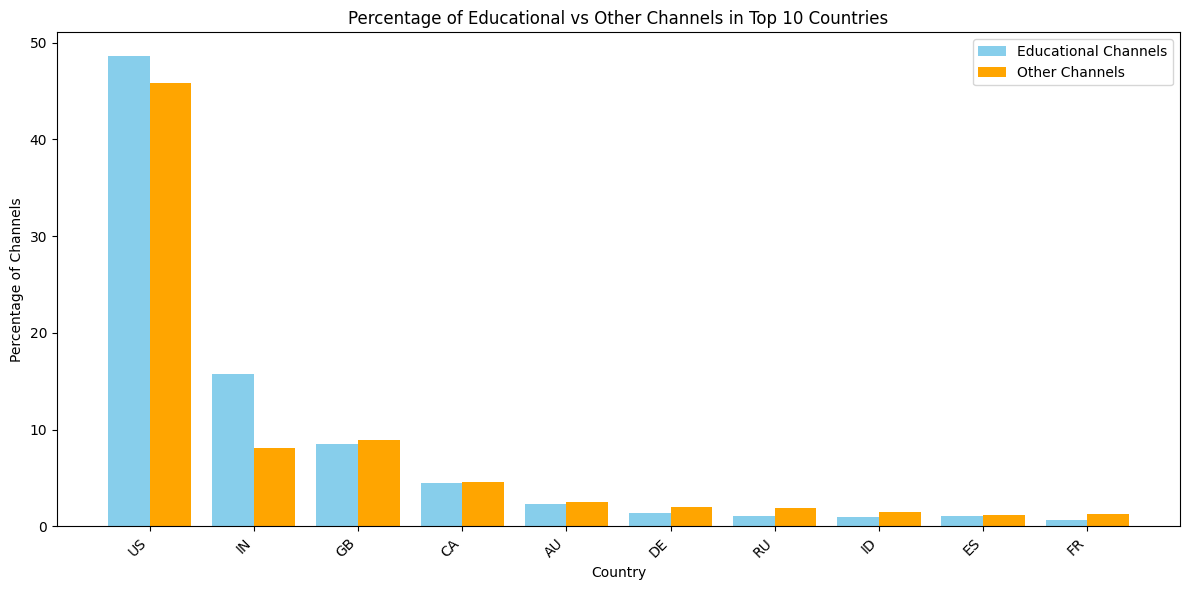

In [8]:
# Calculate the percentage of educational channels and other channels for each country
edu_country_counts = df_channel_edu['country'].value_counts(normalize=True) * 100
other_country_counts = df_channel_other['country'].value_counts(normalize=True) * 100

# Find the top 10 countries based on total percentage
total_counts = edu_country_counts.add(other_country_counts, fill_value=0)
top_10_countries = total_counts.nlargest(10).index

# Create data for the plot
edu_percentages = []
other_percentages = []

for country in top_10_countries:
    edu_percentage = edu_country_counts.get(country, 0)
    other_percentage = other_country_counts.get(country, 0)

    edu_percentages.append(edu_percentage)
    other_percentages.append(other_percentage)

# Create the bar chart with side-by-side bars
data = {'country': top_10_countries, 'edu_percentage': edu_percentages, 'other_percentage': other_percentages}
df_plot = pd.DataFrame(data)

plt.figure(figsize=(12, 6))

x = range(len(top_10_countries))
width = 0.4

plt.bar([i - width/2 for i in x], df_plot['edu_percentage'], width=width, label='Educational Channels', color='skyblue')
plt.bar([i + width/2 for i in x], df_plot['other_percentage'], width=width, label='Other Channels', color='orange')

plt.xlabel('Country')
plt.ylabel('Percentage of Channels')
plt.title('Percentage of Educational vs Other Channels in Top 10 Countries')
plt.xticks(x, top_10_countries, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

The US and most other countries show minimal differences in the distribution between education and other categories. However, India stands out with a notably higher proportion of education channels compared to other types.

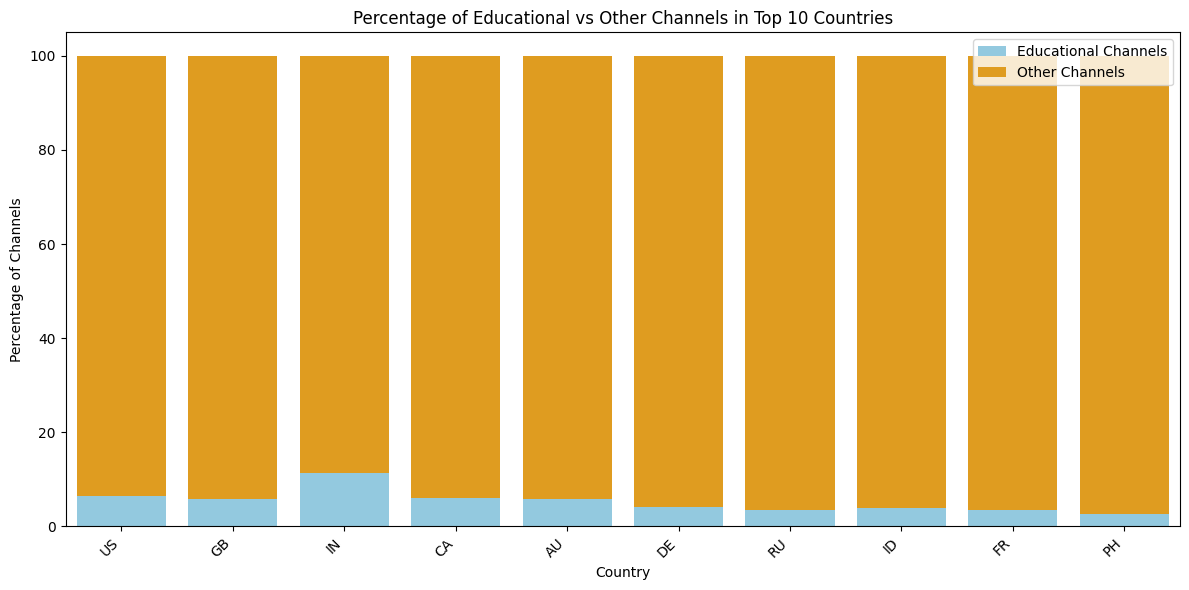

In [9]:
# Calculate the percentage of educational channels and other channels for each country
edu_country_counts = df_channel_edu['country'].value_counts()
other_country_counts = df_channel_other['country'].value_counts()

# Find the top 10 countries based on total channel counts
total_counts = edu_country_counts.add(other_country_counts, fill_value=0)
top_10_countries = total_counts.nlargest(10).index

# Create data for the plot
data = []
for country in top_10_countries:
    edu_count = edu_country_counts.get(country, 0)
    other_count = other_country_counts.get(country, 0)
    total_count = edu_count + other_count

    # Calculate percentages
    edu_percentage = (edu_count / total_count) * 100 if total_count > 0 else 0
    other_percentage = (other_count / total_count) * 100 if total_count > 0 else 0

    data.append({'country': country, 'edu_percentage': edu_percentage, 'other_percentage': other_percentage})

# Convert to DataFrame
df_plot = pd.DataFrame(data)

# Plot the stacked bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='country', y='edu_percentage', data=df_plot, color='skyblue', label='Educational Channels')
sns.barplot(x='country', y='other_percentage', data=df_plot, color='orange', label='Other Channels', bottom=df_plot['edu_percentage'])

# Customize the plot
plt.xlabel('Country')
plt.ylabel('Percentage of Channels')
plt.title('Percentage of Educational vs Other Channels in Top 10 Countries')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

The figure shows the top 10 countries based on percentage of all channel counts.
India (IN) has a higher percentage of educational content compared to other countries even though.

## Many people say... When studying STEM, no matter how hard or how strange a subject is, there's always an Indian Tutor on YouTube to help us pass our exams. Really?

# Now let's take a look at the trend for STEM content...

To identify STEM content, we filtered educational videos using a set of keywords deriving from STEM subjects crawled from MIT OCW. Further details can be found in our project's README, and the code for data preprocessing (STEM video filtering) can be found in src > data_processing

In [ ]:
# Load total edu video and STEM video data
df_videos = pd.read_csv('videos/videos_edu_with_country_nonan.csv')
df_stem_videos = pd.read_csv('videos/videos_stem.csv')

In [34]:
len(df_videos)

2075530

In [35]:
len(df_stem_videos)

74717

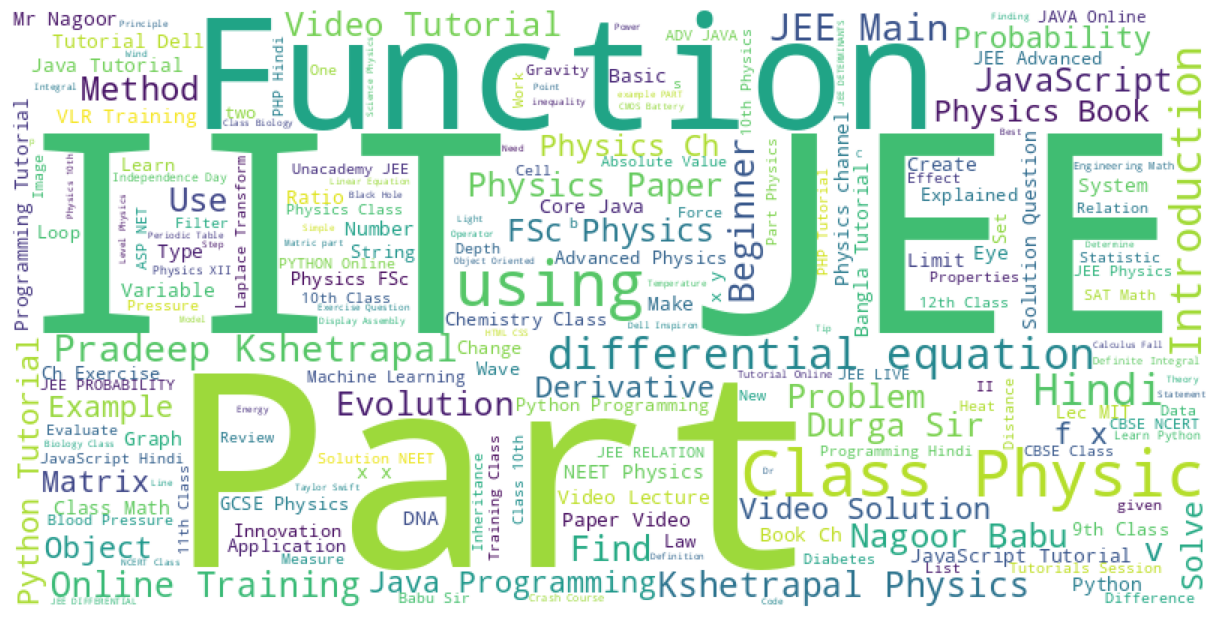

In [9]:
# Combine all titles into a single string
text = " ".join(title for title in df_stem_videos['title'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)

# Display the generated image:
plt.figure(figsize=(12, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

As seen from the word cloud generated from our filtered STEM video titles, we can see various topics such as Physics, Evolution, Machine Learning, Probability and so on. Surprisingly enough, one of the most significant words are IIT and JEE, which stands for Indian Institute of Technology and Joint Entrance Examination, which was formerly All India Engineering Entrance Examination (AIEEE)...?

In [36]:
df_stem_videos.sample(10)

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,name_cc,subscribers_cc,country,is_stem_title,title_matched_keywords,is_stem_tags,tag_matched_tags,tag_matched_keywords
5295,Education,UCsyZSg-iA7aN6C_jJ2hcLNw,2019-11-21 19:09:10.191864,0.0,6l_8-FEQfgc,859,5.0,"restriction fragment length polymorphism,RFLP,...",Forensic DNA typing procedure,2016-04-07 00:00:00,1442.0,Nikolay's Genetics L...,12149.0,US,True,dna,True,"DNA, Genetics, genome, molecular biology, pate...","dna, genetics, genome, molecular biology, testing"
40850,Education,UCUGsMIdvF7TOX_riaBFSvnw,2019-11-03 19:05:39.030922,37.0,tBPr1GX_8Fg,87,65.0,"Impedance relay,protective relay,What is imped...",Impedance or Distance Relay: Impedance relay i...,2017-04-22 00:00:00,15017.0,chrvoje engineering,32700.0,HR,True,distance,True,Impedance relay in distance protection of Powe...,"distance, ratio, torque"
23990,Education,UCcv7pspGHmM7AOywuLM1ufA,2019-11-14 09:01:07.564001,2.0,ZWGUe-OaYAo,3719,10.0,"coordinate geometry,jee mains,jee advanced,IIT...",CLASS 11 | COORDINATE GEOMETRY || LOCUS OF POI...,2018-08-06 00:00:00,412.0,Doubtnut,219000.0,IN,True,rotation,True,"rotation, rotation of axis",rotation
41172,Education,UCTcyOom6rr75j9ht0FVC_jg,2019-11-22 08:09:12.298543,8.0,CO2b6nJ3TbY,510,390.0,"funny,faces,everyday,objects,funny faces,every...",Funny Face in Everyday Objects!,2017-03-26 00:00:00,3045.0,Kelvin Ni,165000.0,US,True,objects,True,"Funny Faces in everyday objects, everyday funn...",objects
64057,Education,UCA7OQkX9AEIVQ6j9i0OSQhA,2019-11-23 11:16:41.343105,4.0,avRyR6BEi9I,3238,52.0,"Organization of HR Department and HR Policies,...",Lecture 2 : Organization of HR Department and ...,2016-05-03 00:00:00,5353.0,cec,281000.0,IN,True,organization,True,Organization of HR Department and HR Policies,organization
31762,Education,UCbQDhzxvT8kGpDdjZT19VQg,2019-11-18 17:42:32.097090,1.0,HhR8Tv_-_to,773,42.0,"Youth,Poetry,Spoken Word,Advocacy,Slam Poetry,...",2015 - 18th Annual Bringing the Noise for MLK ...,2015-03-02 00:00:00,2431.0,Youth Speaks,176000.0,US,True,noise,True,"Bringing the Noise, Bringing the Noise for Dr....",noise
10318,Education,UCpdkWp2zh5Qv1ZWlnqswdCw,2019-11-04 15:12:53.468606,1.0,NOSZdMz5d6Y,3406,7.0,"android php mysql user registration,register u...",Android PHP MySQL User Registration Ep.01 - R...,2016-06-09 00:00:00,1443.0,ProgrammingWizards T...,13200.0,KE,True,php,True,"android php mysql user registration, user regi...",php
45775,Education,UCPiuJvuyMVFSwcIdBCTpTyQ,2019-11-17 02:22:06.927872,6.0,eWbacvoqBPU,560,67.0,"energy,semiconductor,insulator,conductor,energ...",Energy Band Theory - Semiconductors (Chapter 1...,2018-12-18 00:00:00,2748.0,Dronstudy.com,914000.0,IN,True,"energy, physics, semiconductors",True,"band structure, band structure diagram, electr...","energy, physics, structure"
11470,Education,UCn2JOViAAWssWefchGpTNvw,2019-11-17 12:54:10.714930,0.0,niy93tCNoQI,188,2.0,"ADHD Stock Technical Analysis Stock Chart,ADHD...",Alcobra Ltd - ADHD Stock Chart Technical Analy...,2016-09-29 00:00:00,226.0,ClayTrader,187000.0,US,True,"adhd, analysis",True,"ADHD Stock Technical Analysis Chart Review, AD...","adhd, analysis"
58936,Education,UCEBb1b_L6zDS3xTUrIALZOw,2019-11-08 18:49:00.631919,8.0,rMsu4v-UlkA,3533,307.0,"payoff diagram,volatility,volatility implied i...",Ses 11: Options II,2013-05-10 00:00:00,53369.0,MIT OpenCourseWare,2084328.0,US,True,ses,True,"derivative security, volatility, volatility im...","derivative, volatility"


<ipython-input-21-1fa588f4f300>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_countries["total_percentage"] = (top_10_countries["count"] / len(df_videos)) * 100


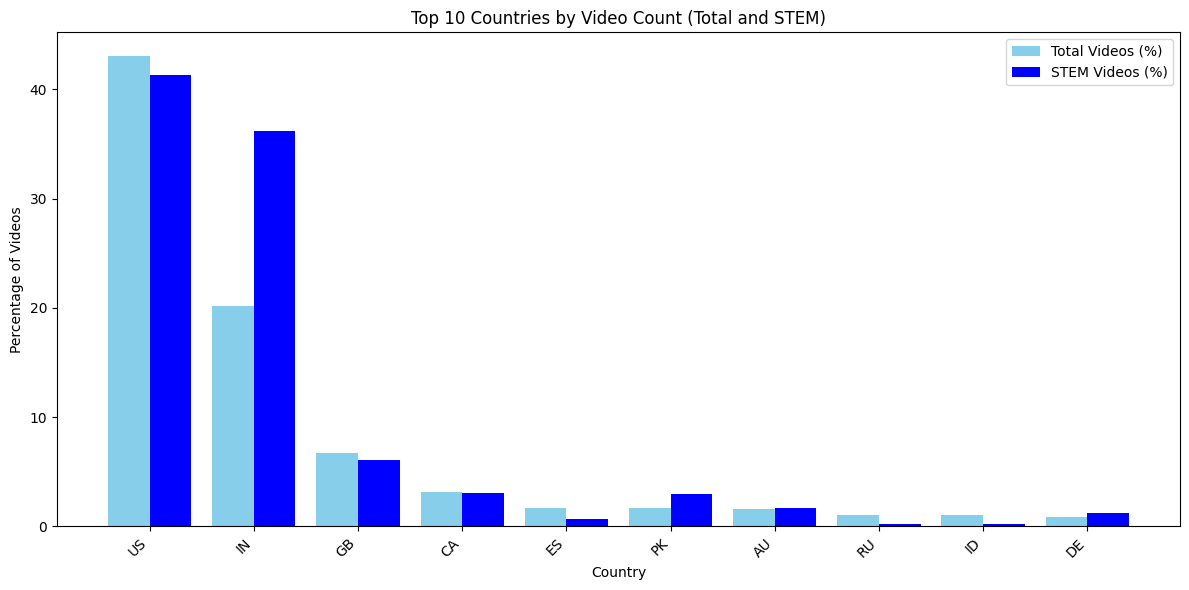

In [21]:
# Group by country and count videos
country_counts = df_videos.groupby("country").size().reset_index(name='count').sort_values('count', ascending=False)

# Get the top 10 countries
top_10_countries = country_counts.head(10)

# Calculate relative percentages
top_10_countries["total_percentage"] = (top_10_countries["count"] / len(df_videos)) * 100

# Similarly, use pandas methods for stem_country_counts
stem_country_counts = df_stem_videos.groupby("country").size().reset_index(name='count').sort_values('count', ascending=False)

# Merge dataframe
top_10_countries = pd.merge(top_10_countries, stem_country_counts, on="country", how="left", suffixes=("_total","_stem"))
top_10_countries["stem_percentage"] = (top_10_countries["count_stem"] / len(df_stem_videos)) * 100
top_10_countries.fillna(0, inplace=True)

# Plotting
plt.figure(figsize=(12, 6))

bar_width = 0.4

# Total Video Percentage
plt.bar(np.arange(len(top_10_countries)), top_10_countries["total_percentage"], width=bar_width, label="Total Videos (%)", color='skyblue')

# STEM Video Percentage
plt.bar(np.arange(len(top_10_countries)) + bar_width, top_10_countries["stem_percentage"], width=bar_width, label="STEM Videos (%)", color='blue')


plt.xlabel("Country")
plt.ylabel("Percentage of Videos")
plt.title("Top 10 Countries by Video Count (Total and STEM)")
plt.xticks(np.arange(len(top_10_countries)) + bar_width / 2, top_10_countries["country"], rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

From the above graph, it seems like the US and India has the significance of STEM Videos percentage compared to others. Let's take a deeper look into this:

In [25]:
# Convert the 'upload_date' column to datetime objects
df_stem_videos['upload_date'] = pd.to_datetime(df_stem_videos['upload_date'], format="%Y-%m-%d %H:%M:%S")

# Extract the year from the 'upload_date'
df_stem_videos['upload_year'] = df_stem_videos['upload_date'].dt.year

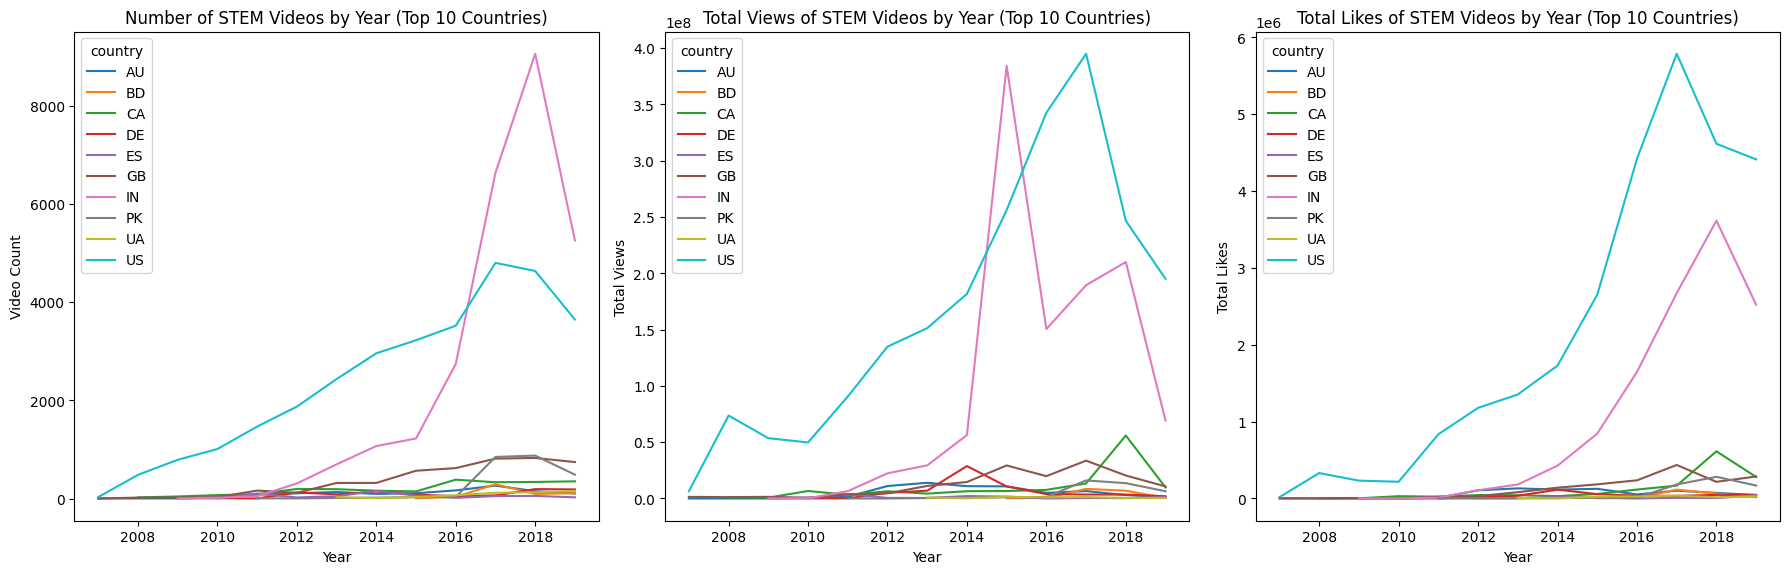

In [13]:
# Group data by country and year
grouped_data = df_stem_videos.groupby(["country", "upload_year"]).agg(
    video_count=("upload_year", "size"),
    total_views=("view_count", "sum"),
    total_likes=("like_count", "sum")
).reset_index()

# Get the top 10 countries with the most STEM videos
stem_country_counts = grouped_data.groupby("country")["video_count"].sum().reset_index()
stem_country_counts = stem_country_counts.rename(columns={"video_count": "count"})
top_10_countries = stem_country_counts.sort_values("count", ascending=False).head(10)
top_10_countries_list = top_10_countries["country"].tolist()

# Filter data for the top 10 countries
top_10_df = grouped_data[grouped_data["country"].isin(top_10_countries_list)]

# Plotting
plt.figure(figsize=(18, 6))

# Setting the hue order
sorted_countries = sorted(top_10_df['country'].unique())

# Video count
plt.subplot(1, 3, 1)
sns.lineplot(x="upload_year", y="video_count", hue="country", hue_order=sorted_countries, data=top_10_df)
plt.title("Number of STEM Videos by Year (Top 10 Countries)")
plt.xlabel("Year")
plt.ylabel("Video Count")

# View count
plt.subplot(1, 3, 2)
sns.lineplot(x="upload_year", y="total_views", hue="country", hue_order=sorted_countries, data=top_10_df)
plt.title("Total Views of STEM Videos by Year (Top 10 Countries)")
plt.xlabel("Year")
plt.ylabel("Total Views")

# Like count
plt.subplot(1, 3, 3)
sns.lineplot(x="upload_year", y="total_likes", hue="country", hue_order=sorted_countries, data=top_10_df)
plt.title("Total Likes of STEM Videos by Year (Top 10 Countries)")
plt.xlabel("Year")
plt.ylabel("Total Likes")

plt.tight_layout()
plt.show()

The United States and India are the leading contributors to STEM video production, views, and engagement. The US emerged early as the dominant player in STEM content, with steady growth in video production, views, and likes. In contrast, India experienced a rapid and aggressive rise starting around 2014, significantly increasing production, viewership, and engagement. Notably, Indian creators surpassed US viewership between 2014 and 2016 before experiencing a decline. Despite India’s surge, the US maintains higher overall engagement, consistently outperforming other countries in total likes and sustaining strong viewership trends.

This highlights the US’s long-standing dominance and India’s rapid growth in the STEM content landscape. Though is this growth stable?

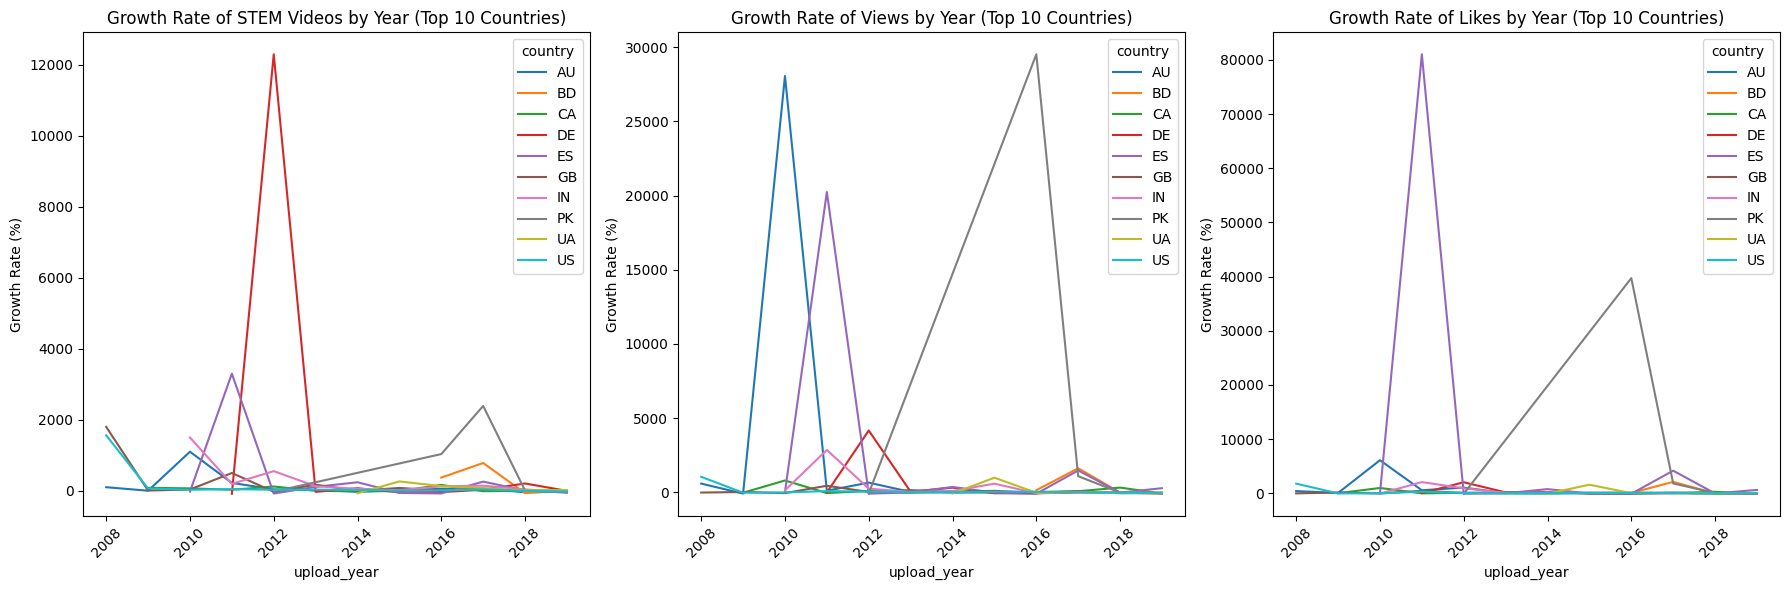

In [40]:
# Calculate year-over-year percentage change
def calculate_growth_rate(df, group_by, column, new_column_name):
    df_sorted = df.sort_values([group_by, 'upload_year'])
    df[new_column_name] = df.groupby(group_by)[column].pct_change() * 100
    return df

# Create a copy to avoid overwriting the original dataframe
top_10_growth_df = top_10_df.copy()

# Apply the function to calculate growth rates
top_10_growth_df = calculate_growth_rate(top_10_growth_df, 'country', 'video_count', 'video_growth_rate')
top_10_growth_df = calculate_growth_rate(top_10_growth_df, 'country', 'total_views', 'views_growth_rate')
top_10_growth_df = calculate_growth_rate(top_10_growth_df, 'country', 'total_likes', 'likes_growth_rate')

# Plotting
plt.figure(figsize=(18, 6))

# Number of videos growth rate
plt.subplot(1, 3, 1)
sns.lineplot(x="upload_year", y="video_growth_rate", hue="country", hue_order=sorted_countries, data=top_10_growth_df)
plt.title("Growth Rate of STEM Videos by Year (Top 10 Countries)")
plt.xticks(rotation=45)
plt.ylabel("Growth Rate (%)")

# Total views growth rate
plt.subplot(1, 3, 2)
sns.lineplot(x="upload_year", y="views_growth_rate", hue="country", hue_order=sorted_countries, data=top_10_growth_df)
plt.title("Growth Rate of Views by Year (Top 10 Countries)")
plt.xticks(rotation=45)
plt.ylabel("Growth Rate (%)")

# Total likes growth rate
plt.subplot(1, 3, 3)
sns.lineplot(x="upload_year", y="likes_growth_rate", hue="country", hue_order=sorted_countries, data=top_10_growth_df)
plt.title("Growth Rate of Likes by Year (Top 10 Countries)")
plt.xticks(rotation=45)
plt.ylabel("Growth Rate (%)")

plt.tight_layout()
plt.show()


While other countries also had certain surges of STEM videos content creation at some point in time, they seem to eventually die down. India, on the other hand, while only witnessed a small peak around 2012, and but then keep growing at a stable rate.

In [9]:
df_stem_india = df_stem_videos[df_stem_videos['country'] == 'IN']
print(f"Total number of STEM videos from India: {len(df_stem_india)}")
df_stem_india_counts = df_stem_india['name_cc'].value_counts()
print(f"Number of unique STEM videos from India: {len(df_stem_india_counts)}")
df_stem_india_counts

Total number of STEM videos from India: 27049
Number of unique STEM videos from India: 472


,count
name_cc,
Doubtnut,3058
Ekeeda,2822
Durga Software Solut...,2420
Pradeep Kshetrapal,1149
Geeky Shows,1119
...,...
Tech Garden,1
Skill Bill : Tally G...,1
BV Pattabhiram,1


The data reveals a notable concentration of Indian content creators producing educational or STEM-related content, with 27049 videos of 74717 STEM-classified videos. Specifically:

Channels like DoubtNut (3058 videos), Ekeeda (2822 videos), and Durga Software Solutions (2420 videos) are among the most prolific.
472 unique content creators, indicating a wide range of contributors in the field. There are many smaller channels with just one video each, highlighting a long tail of niche creators.

# Videos and Channel Characteristics
Now let's take a look at the different characteristics of Indian STEM videos creation/creator. Are these factors what define their success?
## Topic breakdown - What are they teaching on Youtube?

Let's get our keyword list back to match our STEM content to the subject that it's associated with:

In [4]:
def load_keywords(filepath):
    keywords_dict = {}
    with open(filepath, 'r') as file:
        for line in file:
            match = re.match(r"(\w+_keywords)\s*=\s*\[(.*?)\]", line)
            if match:
                category_name = match.group(1)
                keywords_str = match.group(2)
                keywords_list = [keyword.strip("'\" ") for keyword in keywords_str.lower().split(',')]

                # Extract category (e.g., "science" from "science_keywords")
                category = " ".join(category_name.split("_")[:-1])

                keywords_dict[category] = set(keywords_list)
    return keywords_dict

# Example usage (assuming final_keywords.txt is in your current directory):
keywords_data = load_keywords('final_keywords.txt')

In [5]:
keywords_data.keys()

dict_keys(['science', 'physics', 'atomic molecular optical physics', 'theoretical physics', 'condensed matter physics', 'nuclear physics', 'particle physics', 'astrophysics', 'quantum mechanics', 'electromagnetism', 'chemistry', 'physical chemistry', 'analytical chemistry', 'organic chemistry', 'inorganic chemistry', 'biology', 'biochemistry', 'molecular biology', 'genetics', 'neurobiology', 'structural biology', 'synthetic biology', 'microbiology', 'virology', 'anatomy and physiology', 'earth science', 'engineering', 'electrical engineering', 'digital systems', 'signal processing', 'electronics', 'telecommunications', 'electric power', 'mechanical engineering', 'solid mechanics', 'thermodynamics', 'transport processes', 'robotics and control systems', 'systems engineering', 'systems optimization', 'systems design', 'materials science and engineering', 'chemical engineering', 'environmental engineering', 'energy', 'biological engineering', 'cell and tissue engineering', 'biomedical sig

We now match the subject category back to each video by their matched title and tag keywords.

In [ ]:
# Prepare keywords_count dictionary
keywords_count = defaultdict(int)

# Helper function to generate n-grams
def generate_ngrams(text, n):
    words = text.split()
    return [" ".join(words[i:i+n]) for i in range(len(words)-n+1)]

# Function to process a single row
def process_row(idx, row):
    matched_keywords = set(row["title_matched_keywords"].split(", ") + row["tag_matched_keywords"].split(", "))
    matched_categories = set()

    for category, keywords in keywords_data.items():
        for keyword in keywords:
            n = len(keyword.split())  # Determine n for n-grams
            for matched_keyword in matched_keywords:
                ngrams = generate_ngrams(matched_keyword, n)
                if keyword in ngrams:
                    keywords_count[category] += 1
                    matched_categories.add(category)

    return idx, ", ".join(matched_categories)

# Add new column for matched_category
df_stem_india["matched_category"] = ""

# Process rows with ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(lambda x: process_row(x[0], x[1]), df_stem_india.iterrows()), total=len(df_stem_india)))

# Update DataFrame with results
for idx, matched_category in results:
    df_stem_india.at[idx, "matched_category"] = matched_category

In [14]:
# Saving the 'matched_category' column just in case
df_stem_india[['matched_category']].to_csv('india_matched_categories.csv', index=False)

In [54]:
# Convert the 'upload_date' column to datetime objects
df_stem_india['upload_date'] = pd.to_datetime(df_stem_india['upload_date'], format="%Y-%m-%d %H:%M:%S")

# Extract the year from the 'upload_date'
df_stem_india['upload_year'] = df_stem_india['upload_date'].dt.year

In [11]:
df_stem_india[['title','title_matched_keywords','tag_matched_keywords','matched_category']].sample(10)

,title,title_matched_keywords,tag_matched_keywords,matched_category
23358,"IIT JEE DETERMINANTS If `x ,y ,z`\r\nare diffe...","c, determinants","determinants, learning","artificial intelligence, linear algebra"
29369,Core Java Tutorials || Session - 31 || by Mr. ...,java,java,programming languages
30212,ADV. JAVA - SERVLETS || Session - 16 || by M...,java,java,programming languages
3021,HDFC Standard Life Insurance Company Ltd IPO I...,insurance,insurance,econometrics
34497,VTU Engineering Maths 1 Integral reduction exa...,integral,"calculus, functions, integral, integration by ...","programming languages, applied mathematics, co..."
12508,Nyquist Plot - Problem 1 - Frequency Response ...,"analysis, control systems, frequency response","analysis, control, control systems, frequency ...","electrical engineering, systems engineering, n..."
57620,DNA base transition and transversion - DNA poi...,dna,dna,biology
29637,DURGASOFT Python Talent Test: Let us Congratul...,python,java,programming languages
39658,"#11, Methods of sampling in statistics - Part ...","sampling, statistics","sampling, statistics","systems engineering, nuclear physics, signal p..."
73475,#9.1 Dart GETTER and SETTER | Private Instance...,variables,objects,programming languages


Now let's see what STEM subjects that Indians teach the most!

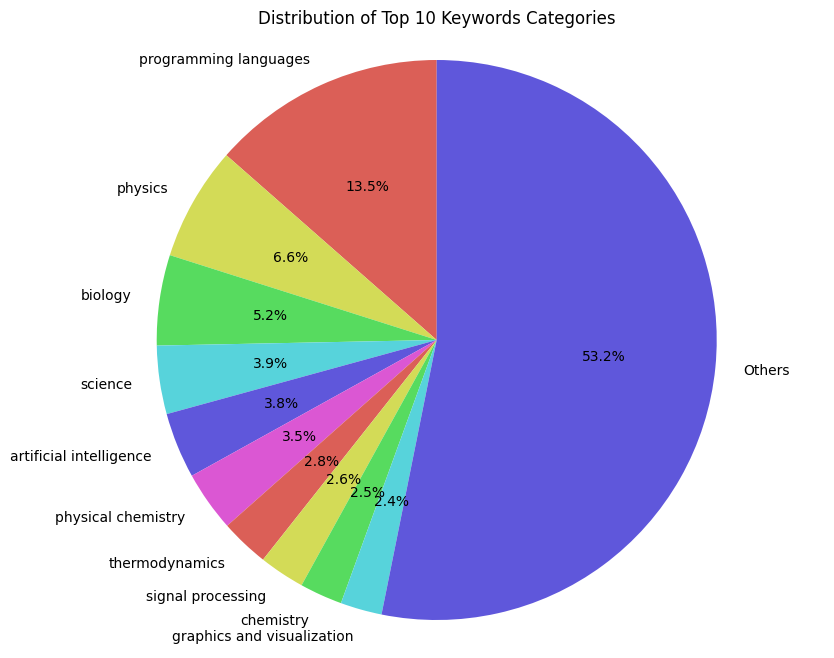

In [12]:
# Sort keywords by count in descending order
sorted_keywords = dict(sorted(keywords_count.items(), key=lambda item: item[1], reverse=True))

# Take the top 10 categories
top_10_keywords = dict(list(sorted_keywords.items())[:10])

# Calculate the sum of counts for the remaining categories
other_count = sum(sorted_keywords.values()) - sum(top_10_keywords.values())

# Add "Others" to the top 10 keywords
top_10_keywords["Others"] = other_count

colors = sns.color_palette('hls')[0:12]

# Create the pie chart
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
plt.pie(top_10_keywords.values(), labels=top_10_keywords.keys(), autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Top 10 Keywords Categories')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Top subjects are programming languages, followed by physics, AI and biology. Now we can extend this to look at how these subjects have emerged overtime, especially in compare with other countries.

In [23]:
# This code does the same thing bs before ut now we are running over the whole stem videos

# Prepare keywords_count dictionary
keywords_count = defaultdict(int)

# Helper function to generate n-grams
def generate_ngrams(text, n):
    words = text.split()
    return [" ".join(words[i:i+n]) for i in range(len(words)-n+1)]

# Function to process a single row
def process_row(idx, row):
    matched_keywords = set(row["title_matched_keywords"].split(", ") + row["tag_matched_keywords"].split(", "))
    matched_categories = set()

    for category, keywords in keywords_data.items():
        for keyword in keywords:
            n = len(keyword.split())  # Determine n for n-grams
            for matched_keyword in matched_keywords:
                ngrams = generate_ngrams(matched_keyword, n)
                if keyword in ngrams:
                    keywords_count[category] += 1
                    matched_categories.add(category)

    return idx, ", ".join(matched_categories)

# Add new column for matched_category
df_stem_videos["matched_category"] = ""

# Process rows with ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(lambda x: process_row(x[0], x[1]), df_stem_videos.iterrows()), total=len(df_stem_videos)))

# Update DataFrame with results
for idx, matched_category in results:
    df_stem_videos.at[idx, "matched_category"] = matched_category


100%|██████████| 74717/74717 [09:57<00:00, 125.13it/s]


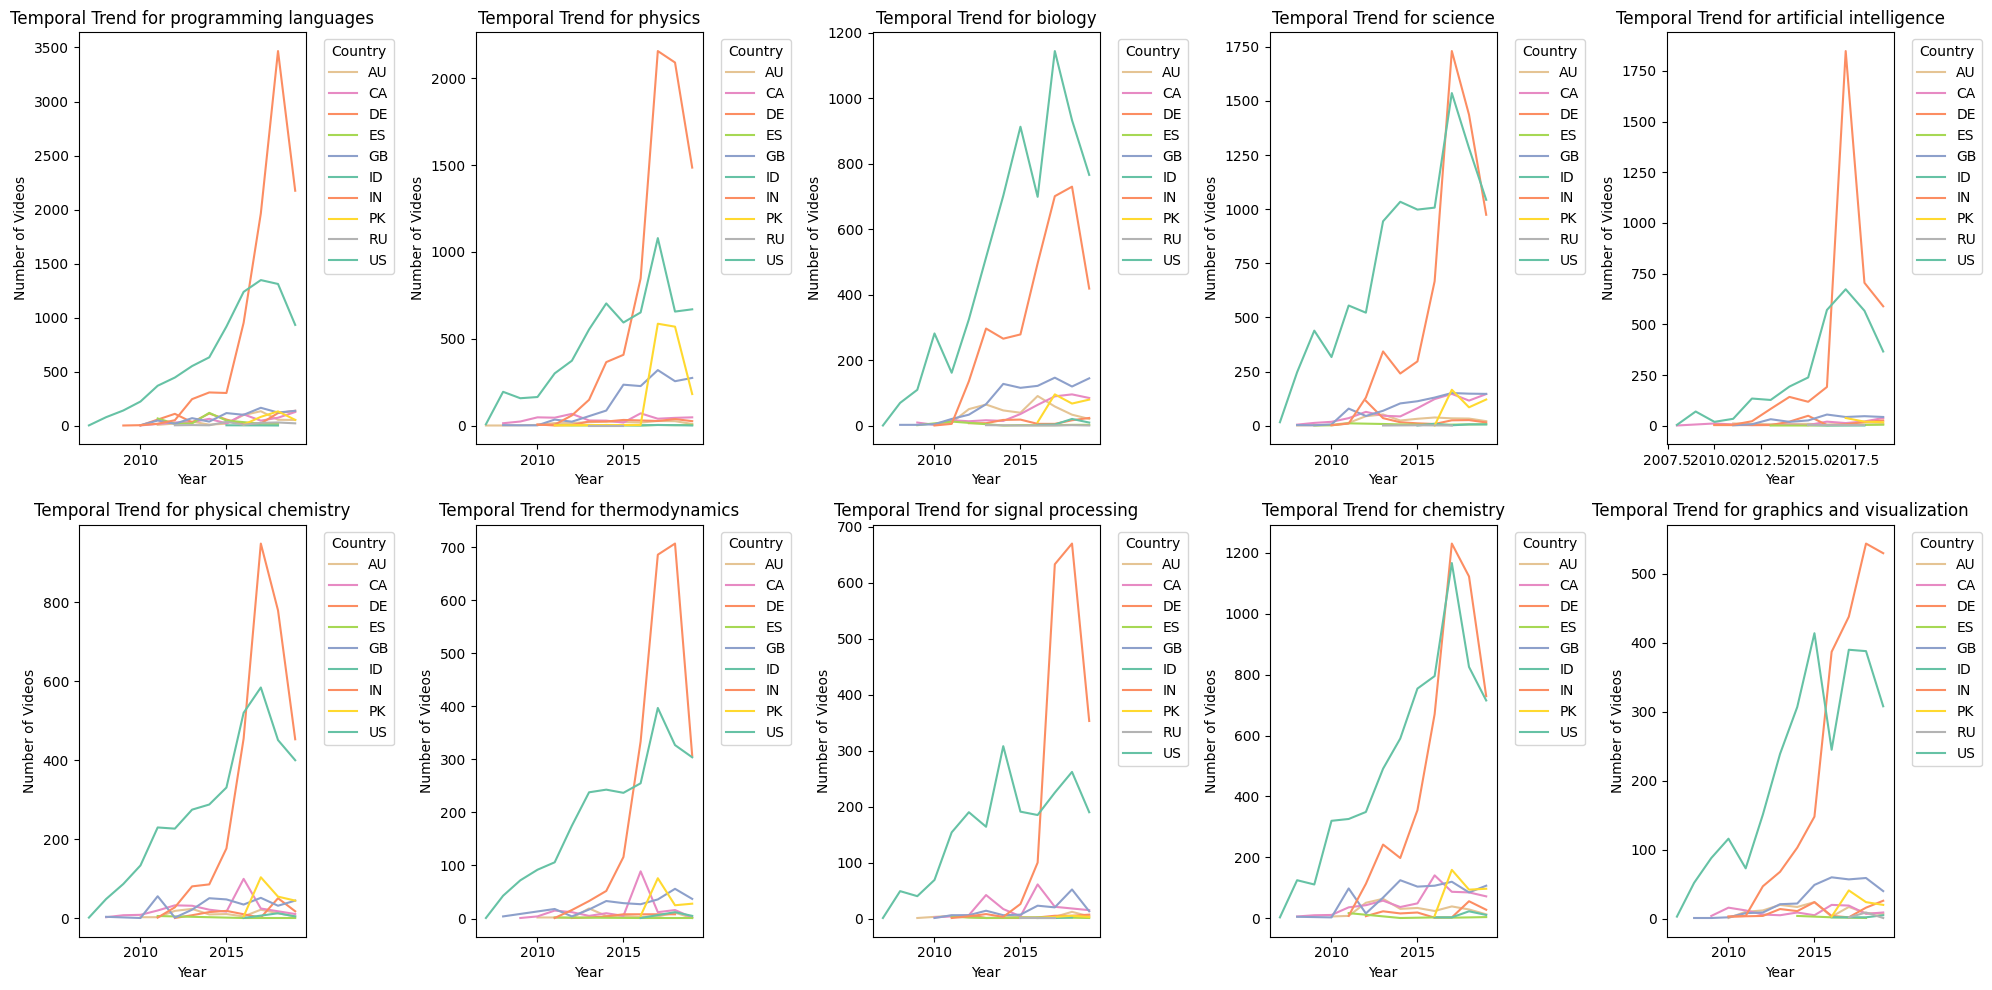

In [45]:
# Filter for top 10 categories
df_top_categories = df_stem_videos[df_stem_videos['matched_category'].str.contains('|'.join(top_10_keywords), na=False)]

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.ravel()

# Define a consistent color palette for the top 10 countries
color_palette = sns.color_palette("Set2", n_colors=len(top_10_countries_list))  # Choose a palette with enough colors

# Create a dictionary to map each country to a color
country_color_map = {country: color_palette[i] for i, country in enumerate(top_10_countries_list)}

# Plotting
for i, category in enumerate(list(top_10_keywords.keys())[:10]):
    category_data = df_top_categories[df_top_categories["matched_category"].str.contains(category, na=False)]

    # Group by country and upload_year for this category
    grouped_data = category_data.groupby(["country", "upload_year"]).size().reset_index(name='video_count')

    # Filter grouped data for top 10 countries
    top_10_country_data = grouped_data[grouped_data['country'].isin(top_10_countries_list)]

    sns.lineplot(ax=axes[i], x="upload_year", y="video_count", hue="country", data=top_10_country_data, palette=country_color_map)
    axes[i].set_title(f'Temporal Trend for {category}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Number of Videos')
    axes[i].legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [46]:
# Saving the new column (matched_category) just in case
df_matched_cat = df_stem_videos[['display_id', 'country', 'matched_category']]

# Save the subset to a CSV file
df_matched_cat.to_csv('stem_videos_with_matched_category.csv', index=False)

We can observe a clear trend where the key players in the top STEM categories are India and the U.S. While the U.S. began much earlier than India, India experienced a faster surge, at times even surpassing the U.S

## Is monetization the drive for content creation?

In [ ]:
import json

# Load the JSON data
with open('monetization_labels.json', 'r') as f:
    domains_dict_labels = json.load(f)

In [5]:
# Checking the quality of the keywords

import nltk
from nltk.corpus import stopwords

In [ ]:
# Download the stopwords list if not already downloaded
nltk.download('stopwords')

In [57]:
# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Keyword list
keywords = domains_dict_labels.keys()

# Function to check if a word is a stopword, a number, or insignificant
def check_insignificant_words(keyword_list):
    insignificant_words = []
    significant_words = []

    for word in keyword_list:
        if word.lower() in stop_words or re.fullmatch(r'\d+', word):
            insignificant_words.append(word)
        else:
            significant_words.append(word)

    return insignificant_words, significant_words

# Check keywords
insignificant, significant = check_insignificant_words(keywords)

# Print the results
print(f"Insignificant words example (stopwords or numbers): {insignificant[:10]}")
print(f"Count: {len(insignificant)}")
print(f"Significant words example: {significant[:10]}")
print(f"Count: {len(significant)}")

Insignificant words example (stopwords or numbers): ['very', '5', '7', '34', '12', '8', 'again', '1999', 'to', '17']
Count: 30
Significant words example: ['amazon', 'patreon', 'paypal', 'ebay', 'teespring', 'streamlabs', 'etsy', 'hugedomains', 'gofundme', 'kickstarter']
Count: 39213


In [8]:
# Remove insignificant words from domains_dict_labels
filtered_domains_dict_labels = {key: value for key, value in domains_dict_labels.items() if key not in insignificant}

print(f"Original dictionary length: {len(domains_dict_labels)}")
print(f"Filtered dictionary length: {len(filtered_domains_dict_labels)}")

# Print the filtered dictionary
len(filtered_domains_dict_labels)

Original dictionary length: 39243
Filtered dictionary length: 39213


39213

In [11]:
unique_values = set()
for value in domains_dict_labels.values():
    unique_values.add(value)

unique_values

{'donation', 'merch_channel', 'merch_others'}

In [14]:
df_stem_w_desc = pd.read_csv('videos/videos_stem_with_descriptions.csv', low_memory=False)

# Add new categorical columns, initialized to 0
for value in unique_values:
    df_stem_w_desc[value] = 0

# Efficiently iterate through DataFrame rows and update categorical columns
for index, row in tqdm(df_stem_w_desc.iterrows(), total=len(df_stem_w_desc)):
    description = str(row['description']).lower()  # Handle potential missing descriptions
    for keyword, category in filtered_domains_dict_labels.items():
        if keyword in description:
            df_stem_w_desc.loc[index, category] = 1
            break  # Exit inner loop once a match is found for the current row


# Print the counts for each category and rows with all zeros
for col in unique_values:
    count_one = df_stem_w_desc[df_stem_w_desc[col] == 1].shape[0]
    print(f"Rows with '{col}' = 1: {count_one}")

# Count rows with all new columns equal to 0
count_zero = df_stem_w_desc[df_stem_w_desc[list(unique_values)].sum(axis=1) == 0].shape[0]
print(f"Rows with all new columns = 0: {count_zero}")

100%|██████████| 74723/74723 [01:26<00:00, 863.60it/s]

Rows with 'merch_others' = 1: 61191
Rows with 'merch_channel' = 1: 1096
Rows with 'donation' = 1: 6204
Rows with all new columns = 0: 6232


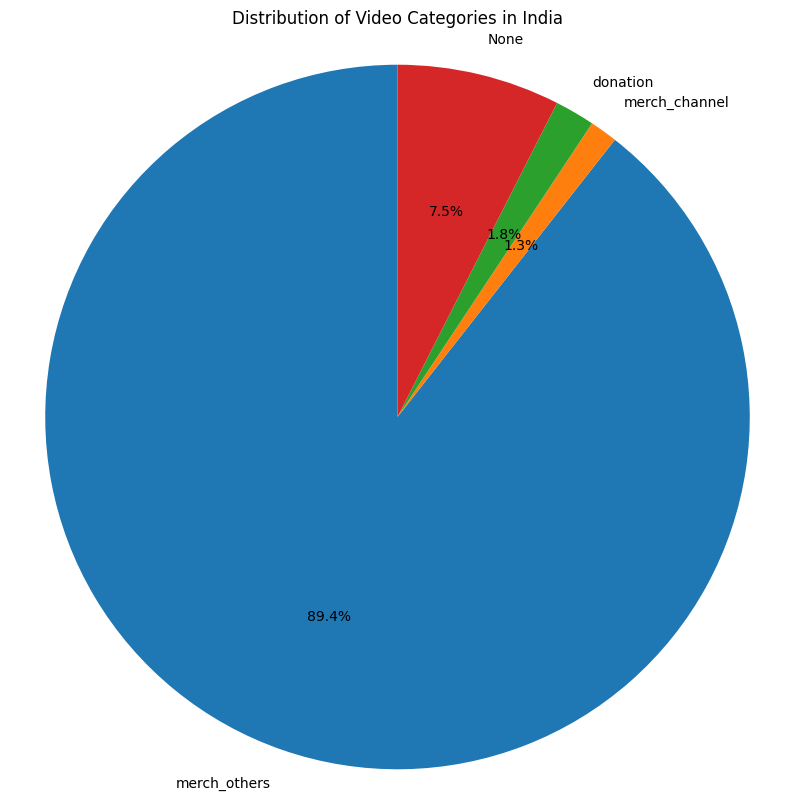

In [15]:
# Filter for Indian videos
df_stem_w_desc_indian = df_stem_w_desc[df_stem_w_desc['country'] == 'IN']

# Calculate category counts for Indian videos
category_counts = {}
for col in unique_values:
    category_counts[col] = df_stem_w_desc_indian[df_stem_w_desc_indian[col] == 1].shape[0]

# Add count for videos with none of the categories
count_zero_in = df_stem_w_desc_indian[df_stem_w_desc_indian[list(unique_values)].sum(axis=1) == 0].shape[0]
category_counts['None'] = count_zero_in

# Create the pie chart
labels = list(category_counts.keys())
sizes = list(category_counts.values())

plt.figure(figsize=(10, 10))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Video Categories in India')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

Let's also look at the trend for other countries:

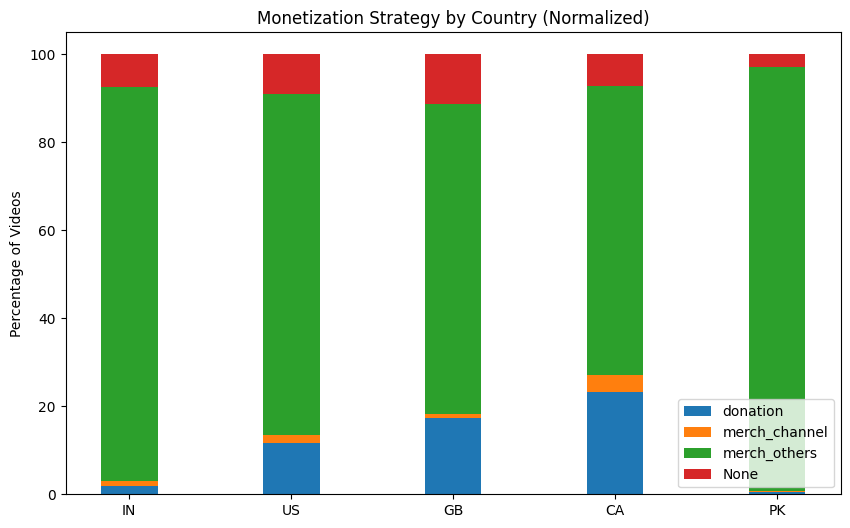

In [23]:
def plot_monetization_strategy(df, countries):
    monetization_strategies = ['donation', 'merch_channel', 'merch_others', 'None']

    # Create a dictionary to store the counts for each country and monetization strategy
    strategy_counts = {}
    for country in countries:
        strategy_counts[country] = {}
        country_df = df[df['country'] == country]
        total_videos = len(country_df)

        for strategy in monetization_strategies:
            if strategy == 'None':
                # Count videos with none of the specified monetization strategies
                strategy_counts[country][strategy] = len(country_df[
                    (country_df['donation'] == 0) &
                    (country_df['merch_channel'] == 0) &
                    (country_df['merch_others'] == 0)
                ])
            else:
                strategy_counts[country][strategy] = len(country_df[country_df[strategy] == 1])

        # Normalize the counts to 100% for each country
        for strategy in monetization_strategies:
            strategy_counts[country][strategy] = (strategy_counts[country][strategy] / total_videos) * 100

    # Create the stacked bar chart
    width = 0.35  # the width of the bars
    x = np.arange(len(countries))

    fig, ax = plt.subplots(figsize=(10, 6))

    bottom = np.zeros(len(countries))
    for strategy in monetization_strategies:
        values = [strategy_counts[country][strategy] for country in countries]
        ax.bar(x, values, width, label=strategy, bottom=bottom)
        bottom += values

    ax.set_ylabel('Percentage of Videos')
    ax.set_title('Monetization Strategy by Top 5 Country (Normalized)')
    ax.set_xticks(x)
    ax.set_xticklabels(countries)
    ax.legend()
    plt.show()

# Example usage (replace with your actual DataFrame and desired countries)
countries_to_plot = ['IN', 'US', 'GB', 'CA', 'PK'] # The top 5 countries obtained in earlier analysis
plot_monetization_strategy(df_stem_w_desc, countries_to_plot)

It's clear that each country implement different monetization strategy for their STEM content, but it's not yet clear what is the effect of each of these monetizations strategy is for the video creation. Again let's take a closer look at India:

In [18]:
# Print some random samples of the matched keywords for merch_others in indian stem videos

import random
# Get the keywords associated with 'merch_others'
merch_others_keywords = [keyword for keyword, category in filtered_domains_dict_labels.items() if category == 'merch_others']

# Function to get random samples from description containing the keyword
def get_random_samples(df, keyword_list, num_samples=5):
    matching_rows = []
    for index, row in df.iterrows():
        description = str(row['description']).lower()
        for keyword in keyword_list:
          if keyword in description:
            matching_rows.append(row['description'])
            break
    if matching_rows:
      return random.sample(matching_rows, min(num_samples, len(matching_rows)))
    else:
      return ["No matching descriptions found."]


# Get random samples for 'merch_others' in Indian videos
samples = get_random_samples(df_stem_w_desc_indian, merch_others_keywords)


# Print the samples
for i, sample in enumerate(samples):
    print(f"Sample {i+1}:\n{sample}\n")

Sample 1:
Launch Your First Android app with our TOP course at 82% OFF (24 hrs ONLY) HERE https://goo.gl/7veBXc
"Learn How To Design + Code A Complete App From Scratch To Playstore" 
âž¨ https://www.youtube.com/watch?v=aWGGZCOHZ1k
-~-~~-~~~-~~-~-

This video shows how to build a RelativeLayout in Java code using RelativeLayout.LayoutParams class and creating other View objects
Check us out at http://facebook.com/Slidenerd

Sample 2:
Question From - NCERT Maths Class 12 Chapter 7 EXERCISE 7.9 Question – 12 INTEGRALS CBSE, RBSE, UP, MP, BIHAR BOARD

QUESTION TEXT:-
Evaluate the definite integrals `int_0^(pi/2)cos^2xdx`

Doubtnut  के साथ १००%  मार्क्स पायें, आज ही डाउनलोड करें :-
https://doubtnut.app.link/91GzfmKxjP

Related Questions & Solutions:

1. Evaluate the definite integrals `int-1 1(x+1)dx`...
https://youtu.be/rvm3ufXmQyI

2. Evaluate the definite integrals `int_2^3 1/x dx`...
https://youtu.be/qI7zCysjDB8

3. Evaluate the definite integrals `int_1^2(4x^3-5x^2+6x+9)dx`...
https://

In [50]:
# Get the number of videos per channel
video_counts = df_stem_w_desc.groupby('channel_id')['display_id'].count().reset_index(name='video_count')

# Merge video counts back into the original DataFrame
df_stem_w_desc = pd.merge(df_stem_w_desc, video_counts, on='channel_id', how='left', suffixes=('', '_drop'))
df_stem_w_desc['None'] = 0  # Add 'None' column and initialize it with 0s
df_stem_w_desc.loc[(df_stem_w_desc['donation'] == 0) &
                  (df_stem_w_desc['merch_channel'] == 0) &
                  (df_stem_w_desc['merch_others'] == 0), 'None'] = 1

Now we want to see if monetization motivate (Indian) channels to produce more videos. Let's do a regression analysis on each of these (dummy) monetization categories on the number of videos produced:

In [54]:
import statsmodels.formula.api as smf

categorical_cols = ['donation', 'merch_channel', 'merch_others', 'None']
for col in categorical_cols:
    # Check if the column has more than one unique value
    if df_stem_w_desc[col].nunique() > 1:
        # If more than one unique value, create dummy variables
        dummies = pd.get_dummies(df_stem_w_desc[col], prefix=col, drop_first=True)
        df_stem_w_desc = pd.concat([df_stem_w_desc, dummies], axis=1)

# Build the formula for the regression model
# Include only those categorical columns that have dummy variables created
formula_terms = ['video_count ~ 1']  # Start with intercept
for col in categorical_cols:
    if f'{col}_1' in df_stem_w_desc.columns:  # Check if dummy variable exists
        formula_terms.append(f'{col}_1')
formula = ' + '.join(formula_terms)

# Create the model
model = smf.ols(formula=formula, data=df_stem_w_desc)

# Fit the model
results = model.fit()

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            video_count   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     914.3
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:49:19   Log-Likelihood:            -6.1380e+05
No. Observations:               74721   AIC:                         1.228e+06
Df Residuals:                   74717   BIC:                         1.228e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

As can be seen from the regression results, each monetization category has p-value almost ~0, indicating statistical significance. However, this does not imply practical significance, especially given the low R-squared value (0.035 i.e only 3.5% of the variance in video_count is explained by the monetization categories in the model. This indicates that there might be other variables that affect the video creation strategy in these Indian Youtubers, which we will investigate further in the next section.

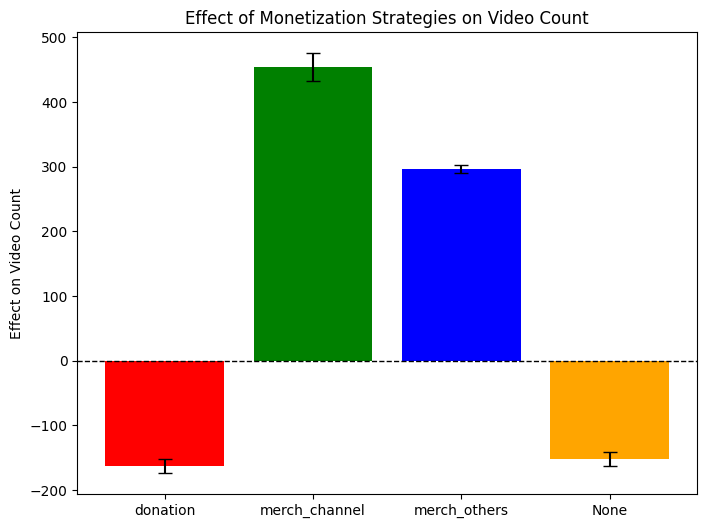

In [56]:
# Coefficients and their confidence intervals
categories = ['donation', 'merch_channel', 'merch_others', 'None']
coefficients = [-163.3315, 453.6957, 296.3191, -152.6345]
errors = [10.829, 21.852, 6.915, 10.814]  # Standard errors

# Plot
plt.figure(figsize=(8, 6))
plt.bar(categories, coefficients, yerr=errors, capsize=5, color=['red', 'green', 'blue', 'orange'])
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.ylabel('Effect on Video Count')
plt.title('Effect of Monetization Strategies on Video Count')
plt.show()

Additionally, the regression results reveal that channels offering merch tend to produce significantly more videos compared to those relying on donation or with none. From the earlier graph, it appears that Indian creators have a notably higher percentage of merchandise as their monetization strategy compared to others. This could provide a potential explanation for why they produce a substantially higher volume of videos than creators from other countries.

In [ ]:
import csv
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict

In [ ]:
stem_videos = pd.read_csv('videos/videos_stem.csv')
stem_categories = pd.read_csv('videos/stem_videos_with_matched_category.csv')
stem_videos['stem_category'] = stem_categories['matched_category']
channels = pd.read_csv('channels/education_channel_with_country.csv')
timeseries = pd.read_csv("channels/df_timeseries_en.tsv.gz",sep="\t")
timeseries = timeseries[timeseries['category'] == 'Education']
timeseries.rename(columns={"channel": "channel_id"}, inplace=True)
channels.rename(columns={"channel": "channel_id"}, inplace=True)

channels_of_interest = stem_videos["channel_id"].unique()
filtered_timeseries = timeseries[timeseries["channel_id"].isin(channels_of_interest)]
channel_info = channels[["channel_id", "join_date", "name_cc", "country"]].drop_duplicates()
merged_data = filtered_timeseries.merge(channel_info, on="channel_id", how="inner")
channels_of_interest = channels[channels['channel_id'].isin(channels_of_interest)]

<ipython-input-81-35ada66b9766>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



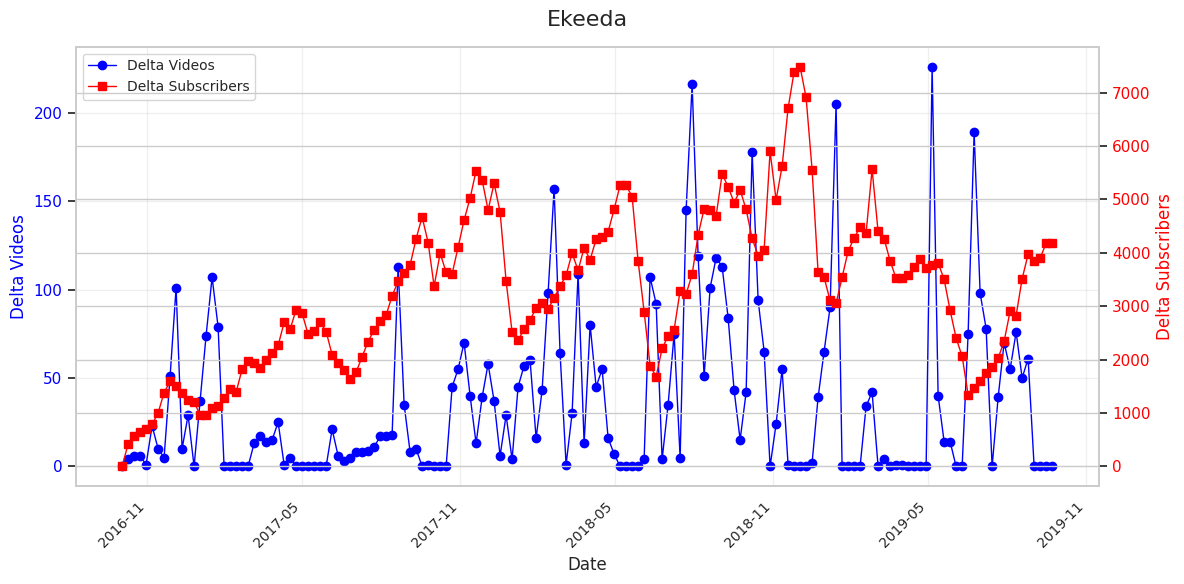

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_time_series_relationship(channel_name, channel_data):
    """
    Plots the time series relationship between delta_videos and delta_subscribers for a given channel.

    Parameters:
        channel_name (str): The name of the channel.
        channel_data (DataFrame): The time series data for the channel, containing
                                  'datetime', 'delta_videos', and 'delta_subs' columns.

    Returns:
        None
    """
    # Ensure 'datetime' is in datetime format
    channel_data['datetime'] = pd.to_datetime(channel_data['datetime'])

    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot delta_videos on the primary y-axis
    ax1.plot(
        channel_data['datetime'], channel_data['delta_videos'],
        label='Delta Videos', color='blue', marker='o', linewidth=1
    )
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Delta Videos', color='blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis for delta_subscribers
    ax2 = ax1.twinx()
    ax2.plot(
        channel_data['datetime'], channel_data['delta_subs'],
        label='Delta Subscribers', color='red', marker='s', linewidth=1
    )
    ax2.set_ylabel('Delta Subscribers', color='red', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='red')

    # Add title
    ax1.set_title(f"{channel_name}", fontsize=16, pad=15)
    ax1.grid(alpha=0.3)

    # Format the x-axis for better readability
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Show year and month
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Tick every 6 months
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=10)  # Rotate xticks

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10)

    # Add tight layout for proper spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
# Filter data for a specific channel
channel_name = "Ekeeda"
channel_id = "UCltVEZ6GecWntoZ19FvaWhQ"
channel_data_filtered = channel_data[channel_data['channel_id'] == channel_id]

# Plot
plot_time_series_relationship(channel_name, channel_data_filtered)

In [ ]:
channel_data = channel_data[channel_data['name_cc'] == 'Webslesson']

**This channel sometimes uploads more than 100 videos in a week!**

Ekeeda is a education center for teaching STEM content (It contains almost everything in STEM).While there are instances where a spike in uploads is followed by a rise in subscriber growth(e.g., around mid-2017 and mid-2018), this is not always consistent. In some weeks, high upload counts do not correspond to significant subscriber gains, suggesting that quantity alone may not guarantee growth.

While frequent uploads can drive some growth, the lack of consistent alignment suggests that content quality, relevance, and timing also play significant roles.

Channels like this one may aim for mass content production to target a broad audience, relying on volume rather than individual video performance.

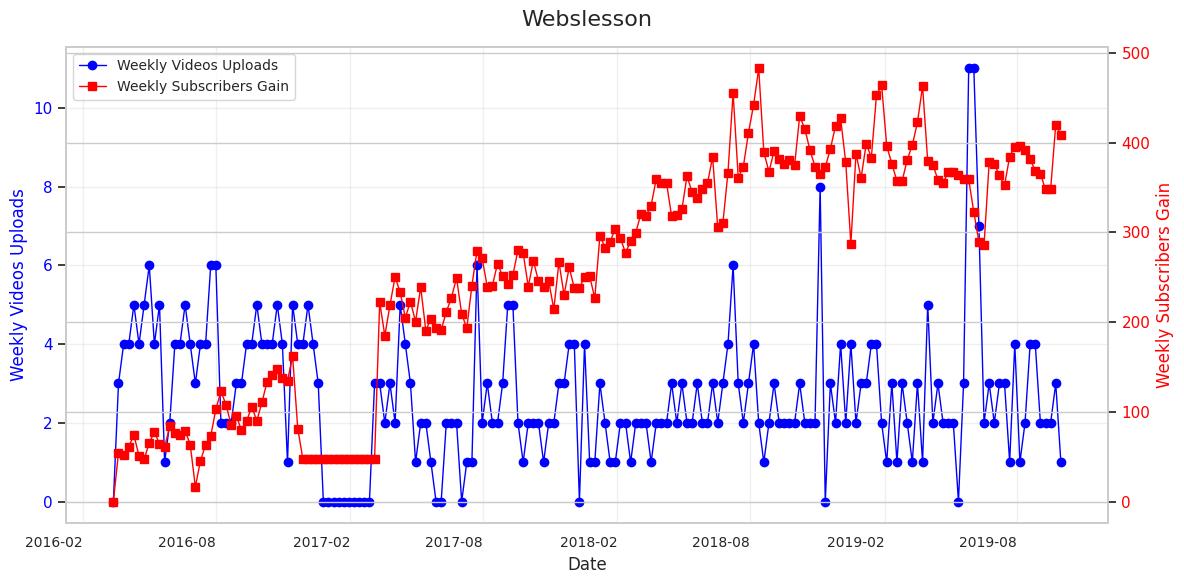

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_time_series_relationship(channel_name, channel_data):
    """
    Plots the time series relationship between delta_videos and delta_subscribers for a given channel.

    Parameters:
        channel_name (str): The name of the channel.
        channel_data (DataFrame): The time series data for the channel, containing
                                  'datetime', 'delta_videos', and 'delta_subs' columns.

    Returns:
        None
    """
    # Ensure 'datetime' is in datetime format
    channel_data['datetime'] = pd.to_datetime(channel_data['datetime'])

    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot delta_videos on the primary y-axis
    ax1.plot(
        channel_data['datetime'], channel_data['delta_videos'],
        label='Weekly Videos Uploads', color='blue', marker='o', linewidth=1
    )
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Weekly Videos Uploads', color='blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis for delta_subscribers
    ax2 = ax1.twinx()
    ax2.plot(
        channel_data['datetime'], channel_data['delta_subs'],
        label='Weekly Subscribers Gain', color='red', marker='s', linewidth=1
    )
    ax2.set_ylabel('Weekly Subscribers Gain', color='red', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='red')

    # Add title
    ax1.set_title(f"{channel_name}", fontsize=16, pad=15)
    ax1.grid(alpha=0.3)

    # Format the x-axis for better readability
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Show year and month
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Tick every 6 months
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0, ha='right', fontsize=10)  # Rotate xticks

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10)

    # Add tight layout for proper spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
# Filter data for a specific channel
channel_name = "Webslesson"
channel_id = "UC8Nbgc4vUi27HgBv2ffEiHw"
channel_data_filtered = channel_data[channel_data['channel_id'] == channel_id]

# Plot
plot_time_series_relationship(channel_name, channel_data_filtered)

**This Channel uploaded videos more regularly.**

The general alignment between upload frequency and subscriber growth suggests that regular uploads contribute to steady growth. However, the occasional spikes in delta_subs suggest that individual video performance or external factors have a significant impact.

In [ ]:
# Group by channel_id and calculate correlations
def compute_correlation(group):
    return pd.Series({
        "corr_activity_delta_subs": group["activity"].corr(group["delta_subs"]),
        "corr_activity_delta_views": group["activity"].corr(group["delta_views"]),
    })

correlations = merged_data.groupby("channel_id").apply(compute_correlation).reset_index()

In [ ]:
from scipy.stats import t
import numpy as np

# Function to compute correlation and 95% CI
def compute_ci(data, column):
    mean = data[column].mean()
    std = data[column].std()
    n = len(data)
    ci = t.ppf(0.975, df=n-1) * (std / np.sqrt(n))  # 95% CI
    return mean, mean - ci, mean + ci

# Group by channel_id and calculate correlations for both activity and delta_videos
def compute_correlation(group):
    return pd.Series({
        "corr_activity_delta_views": group["activity"].corr(group["delta_views"]),
        "corr_activity_delta_subs": group["activity"].corr(group["delta_subs"]),
        "corr_delta_videos_delta_views": group["delta_videos"].corr(group["delta_views"]),
        "corr_delta_videos_delta_subs": group["delta_videos"].corr(group["delta_subs"]),
    })

correlations = merged_data.groupby("channel_id").apply(compute_correlation).reset_index()

# Compute 95% CI for each type of correlation
correlation_columns = ["corr_activity_delta_views", "corr_activity_delta_subs",
                       "corr_delta_videos_delta_views", "corr_delta_videos_delta_subs"]

ci_results = {}
for column in correlation_columns:
    mean, lower_ci, upper_ci = compute_ci(correlations, column)
    ci_results[column] = {"mean": mean, "lower_ci": lower_ci, "upper_ci": upper_ci}

# Convert CI results to a DataFrame for reference
ci_df = pd.DataFrame(ci_results).T.reset_index()
ci_df.columns = ["Correlation Type", "Mean", "Lower CI", "Upper CI"]
print(ci_df)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



                Correlation Type      Mean  Lower CI  Upper CI
0      corr_activity_delta_views  0.144888  0.133711  0.156065
1       corr_activity_delta_subs  0.101150  0.090416  0.111884
2  corr_delta_videos_delta_views  0.138400  0.128815  0.147985
3   corr_delta_videos_delta_subs  0.098699  0.089417  0.107982


<ipython-input-92-c3054788603d>:21: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



<ipython-input-97-51d1d373e8ac>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




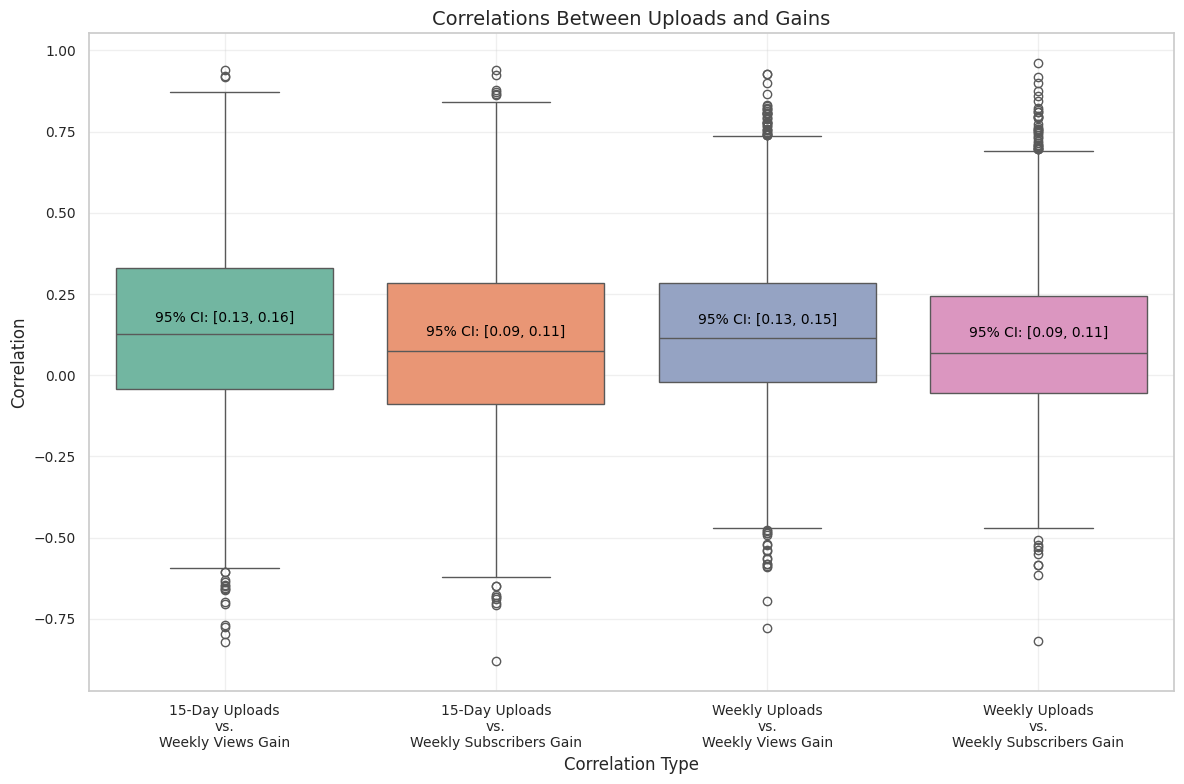

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt correlations for boxplot
correlation_melted = correlations.melt(id_vars=["channel_id"],
                                       value_vars=correlation_columns,
                                       var_name="Correlation Type", value_name="Correlation")

x_label_mapping = {
    "corr_activity_delta_views": "15-Day Uploads\nvs.\nWeekly Views Gain",
    "corr_activity_delta_subs": "15-Day Uploads\nvs.\nWeekly Subscribers Gain",
    "corr_delta_videos_delta_views": "Weekly Uploads\nvs.\nWeekly Views Gain",
    "corr_delta_videos_delta_subs": "Weekly Uploads\nvs.\nWeekly Subscribers Gain"
}

correlation_melted["Correlation Type"] = correlation_melted["Correlation Type"].map(x_label_mapping)

plt.figure(figsize=(12, 8))
sns.boxplot(x="Correlation Type", y="Correlation", data=correlation_melted, palette="Set2")

for i, row in ci_df.iterrows():
    updated_label = x_label_mapping[row["Correlation Type"]]
    plt.text(
        i, row["Mean"] + 0.02,
        f"95% CI: [{row['Lower CI']:.2f}, {row['Upper CI']:.2f}]",
        ha="center", fontsize=10, color="black"
    )

plt.title("Correlations Between Uploads and Gains", fontsize=14)
plt.xlabel("Correlation Type", fontsize=12)
plt.ylabel("Correlation", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()

### More Views during exam seasons?

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# Define seasons
def categorize_season(month):
    if month in [12, 1, 5, 6]:  # Exam season
        return "Exam"
    elif month in [7, 8]:  # Vacation
        return "Vacation"
    else:  # Other months
        return "Other"

# Add season category to the data
merged_data['month'] = pd.to_datetime(merged_data['datetime']).dt.month
merged_data['season'] = merged_data['month'].apply(categorize_season)

# Group by season and calculate statistics
season_stats = merged_data.groupby('season')['views'].agg(['mean', 'median', 'count']).reset_index()
print(season_stats)

# Perform ANOVA to test for differences in views across seasons
views_exam = merged_data[merged_data['season'] == "Exam"]['views']
views_vacation = merged_data[merged_data['season'] == "Vacation"]['views']
views_other = merged_data[merged_data['season'] == "Other"]['views']
f_stat, p_value = f_oneway(views_exam, views_vacation, views_other)
print(f"ANOVA F-Statistic: {f_stat}, P-Value: {p_value}")


     season          mean        median   count
0      Exam  3.652244e+07  3.549169e+06  124137
1     Other  3.681118e+07  3.600682e+06  184059
2  Vacation  3.810889e+07  3.747408e+06   73380
ANOVA F-Statistic: 0.5788189130112593, P-Value: 0.5605605381935264


If we take all channels into accounts, then we will get non-significant result. However, we can run the test for every channel, and we can see what channels have significant higher views during exam seasons

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

# Define Exam Season
def is_exam_season(month):
    return month in [11,12,5,6]

# Add 'is_exam_season' column
merged_data['month'] = pd.to_datetime(merged_data['datetime']).dt.month
merged_data['is_exam_season'] = merged_data['month'].apply(is_exam_season)

# Group by channel and perform t-test for each channel
results = []

for channel_id, group in merged_data.groupby('channel_id'):
    views_exam = group[group['is_exam_season']]['views']
    views_non_exam = group[~group['is_exam_season']]['views']

    # Perform t-test if there is enough data
    if len(views_exam) > 1 and len(views_non_exam) > 1:
        t_stat, p_value = ttest_ind(views_exam, views_non_exam, equal_var=False)  # Welch's t-test
        results.append({
            'channel_id': channel_id,
            'mean_exam_views': views_exam.mean(),
            'mean_non_exam_views': views_non_exam.mean(),
            't_stat': t_stat,
            'p_value': p_value
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Filter channels with significant differences
significant_channels = results_df[results_df['p_value'] < 0.05]

In [ ]:
# Extract unique channel information from merged_data
channel_info = merged_data[['channel_id', 'name_cc','country']].drop_duplicates()

# Merge significant_channels with channel_info
significant_channels_with_info = pd.merge(
    significant_channels,
    channel_info,
    on='channel_id',
    how='left'
)

In [ ]:
# Define exam season
window_size = 3  # For moving average

def is_exam_season(month):
    return month in [11, 12, 5, 6]

# Add 'is_exam_season' column to the merged_data
merged_data['month'] = pd.to_datetime(merged_data['datetime']).dt.month
merged_data['is_exam_season'] = merged_data['month'].apply(is_exam_season)

# Filter data for significant Indian channels
significant_channel_ids = significant_channels_with_info['channel_id'].unique()
significant_channel_data = merged_data[merged_data['channel_id'].isin(significant_channel_ids)]

# Ensure datetime is in the correct format
significant_channel_data['datetime'] = pd.to_datetime(significant_channel_data['datetime'])

# Aggregate delta views and delta videos by date and exam season
aggregated_data = significant_channel_data.groupby(['datetime', 'is_exam_season'])[['delta_views', 'delta_videos']].sum().reset_index()
aggregated_data['datetime'] = aggregated_data['datetime'].dt.date
aggregated_data['smoothed_delta_views'] = aggregated_data['delta_views'].rolling(window=window_size, min_periods=1).mean()
aggregated_data['smoothed_delta_videos'] = aggregated_data['delta_videos'].rolling(window=window_size, min_periods=1).mean()


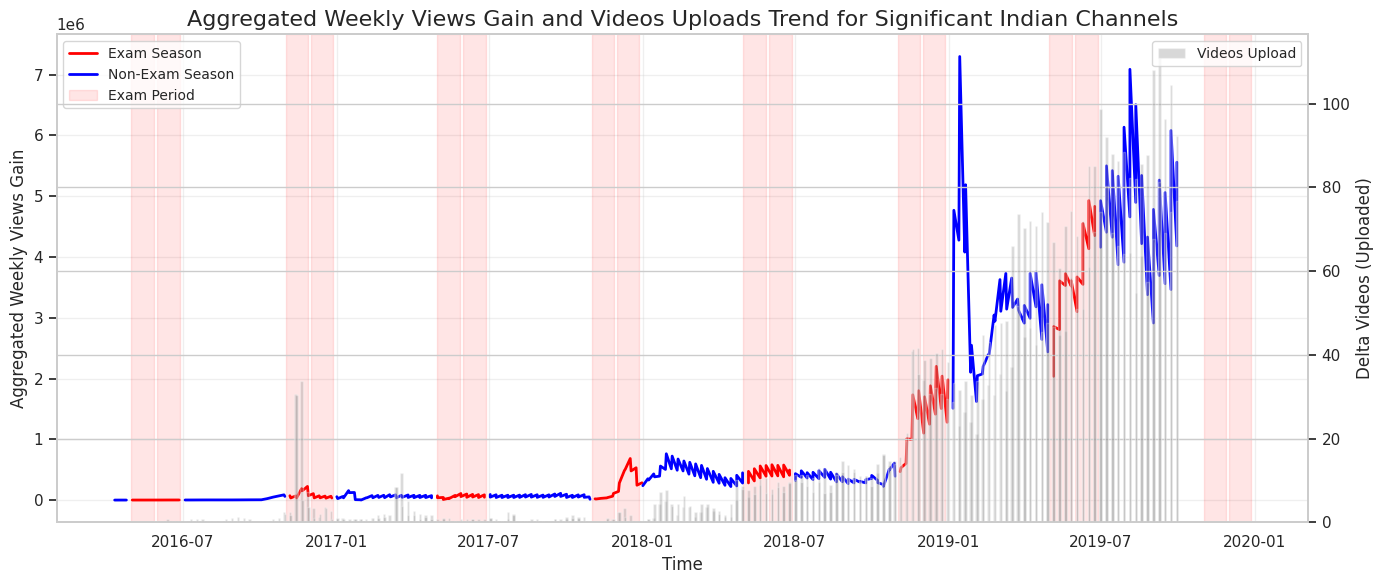

In [ ]:
# Split the data into exam and non-exam periods
exam_data = aggregated_data[aggregated_data['is_exam_season']]
non_exam_data = aggregated_data[~aggregated_data['is_exam_season']]

# Plot the figure with dual Y-axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Line chart for delta_views
for _, group in exam_data.groupby((exam_data['datetime'].diff() > pd.Timedelta(days=7)).cumsum()):
    ax1.plot(group['datetime'], group['smoothed_delta_views'], color='red', label='Exam Season' if 'Exam Season' not in ax1.get_legend_handles_labels()[1] else "", linewidth=2)

for _, group in non_exam_data.groupby((non_exam_data['datetime'].diff() > pd.Timedelta(days=7)).cumsum()):
    ax1.plot(group['datetime'], group['smoothed_delta_views'], color='blue', label='Non-Exam Season' if 'Non-Exam Season' not in ax1.get_legend_handles_labels()[1] else "", linewidth=2)

# Add shaded exam periods
for i, year in enumerate(significant_channel_data['datetime'].dt.year.unique()):
    for month in [11, 12, 5, 6]:
        ax1.axvspan(
            pd.Timestamp(f"{year}-{month}-01"),
            pd.Timestamp(f"{year}-{month}-28"),
            color='red', alpha=0.1,
            label='Exam Period' if i == 0 and month == 11 else ""
        )

# Secondary Y-axis for delta_videos as bar chart
ax2 = ax1.twinx()
ax2.bar(aggregated_data['datetime'], aggregated_data['smoothed_delta_videos'], color='gray', alpha=0.3, label='Videos Upload', width=3)

# Customize primary Y-axis (delta_views)
ax1.set_ylabel("Aggregated Weekly Views Gain", fontsize=12)
ax1.set_xlabel("Time", fontsize=12)
ax1.set_title("Aggregated Weekly Views Gain and Videos Uploads Trend for Significant Indian Channels", fontsize=16)
ax1.legend(loc="upper left", fontsize=10)
ax1.grid(alpha=0.3)

# Customize secondary Y-axis (delta_videos)
ax2.set_ylabel("Delta Videos (Uploaded)", fontsize=12)
ax2.legend(loc="upper right", fontsize=10)

# Tight layout
plt.tight_layout()
plt.show()

We can noticeable increases in delta views, particularly in exam seasons. This suggests that students are more likely to engage with these channels during exams, potentially seeking educational content for preparation.

Over the years, there’s a gradual increase in baseline delta views across both exam and non-exam periods. This could indicate the growing popularity of these educational channels.

# Engagement: inside and outside perspectives

Here, we explore how engaging the Indian STEM video content is and what it can tell about the quality of their education.

## Explore the quantitative metrics


### Update and filter the data
We updated the likes and views count for the data crawled in 2019 to smooth the temporal effects. 
Dislikes are not available in YouTube API since 2021, so we waived usage of this data.
We also added the amount of comments. Comments crawling is added to the following chapter for the most popular videos.

In [ ]:
df = pd.read_csv('data/unique_stem_videos.csv')
api_key = '' #add your key
youtube = build('youtube', 'v3', developerKey=api_key)

In [ ]:
results = {}
fails = []

def callback(request_id: str, response: dict, exception: Exception = None):
    """Callback for video requests. Adds likes, views and comments into the dataframe."""
    if exception is None:
        results[request_id] = response
        comments = {}
        metrics = {'likeCount':None, 'viewCount':None, 'commentCount':None, 'favoriteCount':None}
        
        for item in response['items']:
            for metric in metrics.keys():
                if metric in item['statistics']:
                    metrics[metric] = int(item['statistics'][metric])
            break # in case there are more than on item

        index = df[df['display_id'] == request_id].index
        df.loc[df['display_id'] == request_id, 'like_count'] = metrics['likeCount']
        df.loc[df['display_id'] == request_id, 'view_count'] = metrics['viewCount']
        df.loc[df['display_id'] == request_id, 'comment_count'] = metrics['commentCount']
            
    else:
        fails.append(str(exception))

In [ ]:
batch_size = 50
for i in range(0, len(df), batch_size):
    batch = youtube.new_batch_http_request()
    video_ids = df['display_id'][i:i+batch_size]
    
    for id in video_ids:
        request = youtube.videos().list(
            part='statistics',
            id=id
        )
        batch.add(request, callback=callback, request_id=id)
    batch.execute()

notna_df = df[df[['comment_count', 'like_count', 'fav_count', 'view_count']].notna().all(axis=1)]
notna_df.to_csv('data/videos_with_metrics.csv', index=False)

### Analyse updated videos

First, let's compare the engagement of STEM videos produced in different locations. We'll see how they share views, likes and comments among each other, and what are engagement rates (number of views and likes and comments per 100 views):

In [4]:
df = pd.read_csv('data/videos_with_metrics.csv')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


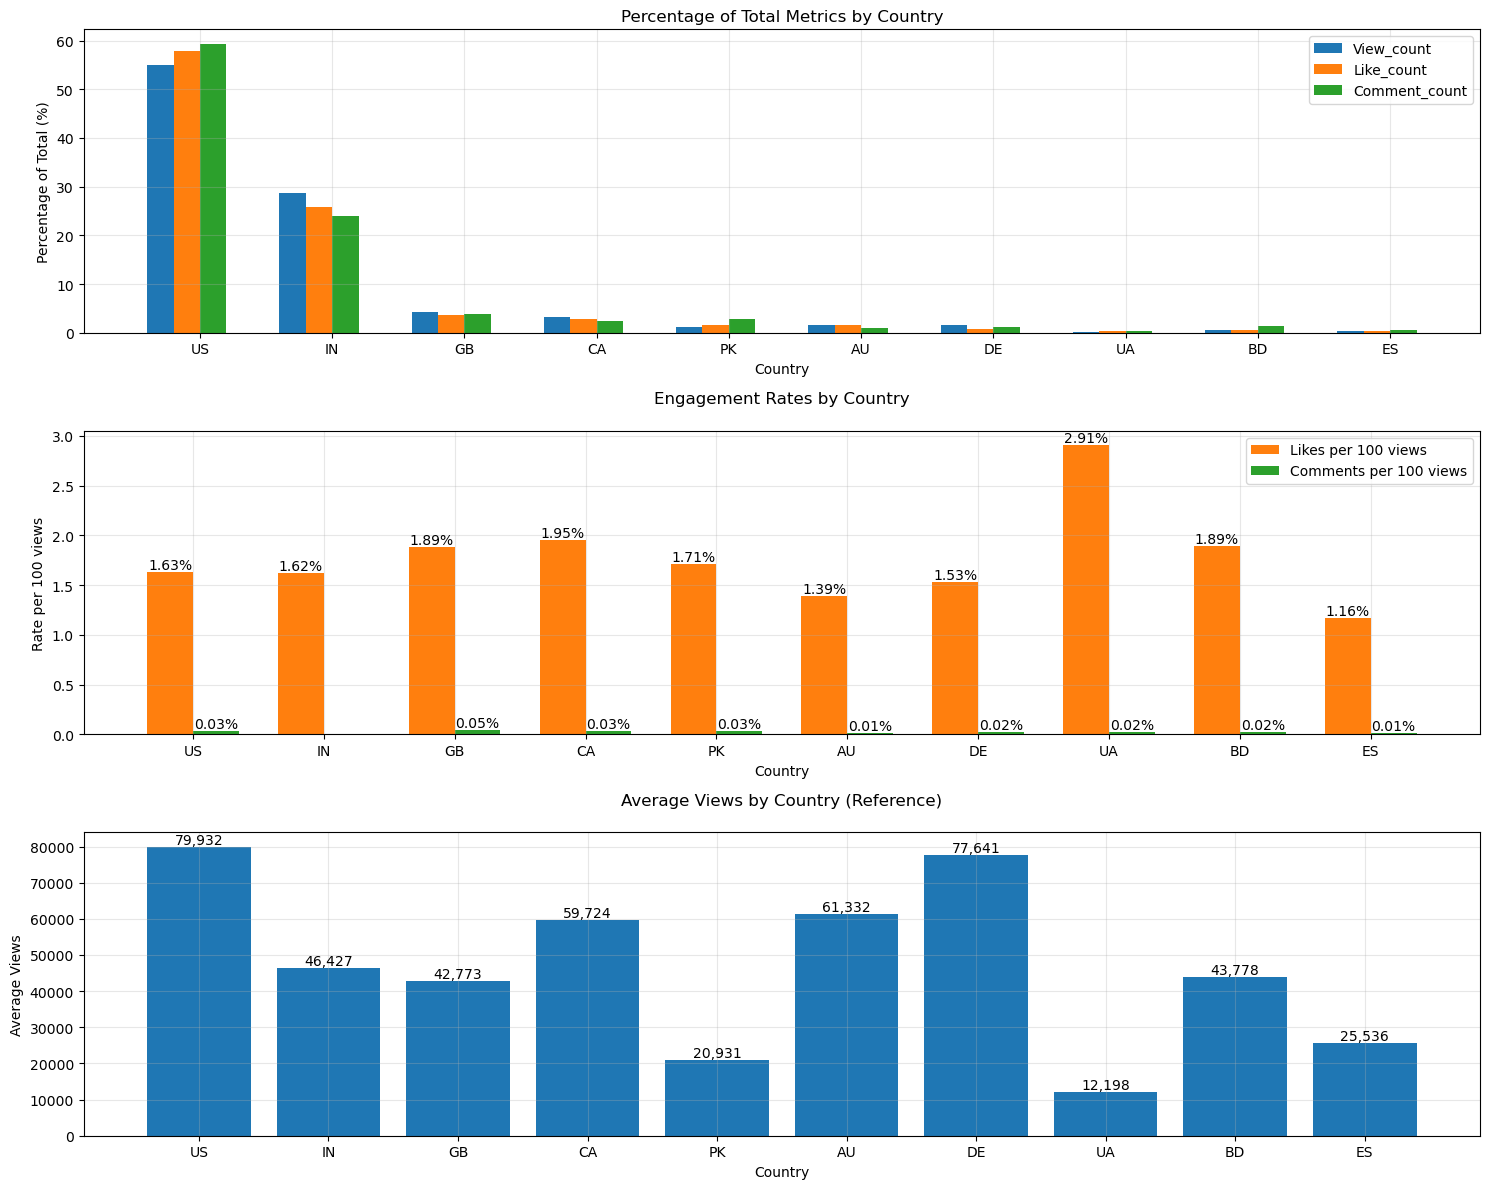

In [5]:
top_countries = df['country'].value_counts().nlargest(10).index
df_top = df[df['country'].isin(top_countries)]
totals = {
    'view_count': df['view_count'].sum(),
    'like_count': df['like_count'].sum(),
    'comment_count': df['comment_count'].sum()
}

metrics = list(totals.keys())
percentages = []
country_stats = []

for country in top_countries:
    country_data = df_top[df_top['country'] == country]
    country_percentages = {'country': country}
    country_averages = {'country': country}
    stats = {
        'country': country,
        'like_rate': (country_data['like_count'] / country_data['view_count'] * 100).mean(),
        'comment_rate': (country_data['comment_count'] / country_data['view_count'] * 100).mean(),
        'avg_views': country_data['view_count'].mean()  # Keep this for reference
    }
    country_stats.append(stats)

    for metric in metrics:
        country_percentages[metric] = (country_data[metric].sum() / totals[metric]) * 100
    percentages.append(country_percentages)
    

df_percentages = pd.DataFrame(percentages)
df_stats = pd.DataFrame(country_stats)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Percentages
bar_width = 0.2
x = np.arange(len(top_countries))

for i, metric in enumerate(metrics):
    ax1.bar(x + i * bar_width, 
            df_percentages[metric], 
            bar_width, 
            label=metric.capitalize())

ax1.set_title('Percentage of Total Metrics by Country')
ax1.set_xlabel('Country')
ax1.set_ylabel('Percentage of Total (%)')
ax1.set_xticks(x + bar_width * 1.5)
ax1.set_xticklabels(df_percentages['country'])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Engagement rates
x = np.arange(len(top_countries))
bar_width = 0.35

ax2.bar(x - bar_width/2, df_stats['like_rate'], bar_width, 
        label='Likes per 100 views', color='#ff7f0e')
ax2.bar(x + bar_width/2, df_stats['comment_rate'], bar_width, 
        label='Comments per 100 views', color='#2ca02c')

ax2.set_title('Engagement Rates by Country', pad=20)
ax2.set_xlabel('Country')
ax2.set_ylabel('Rate per 100 views')
ax2.set_xticks(x)
ax2.set_xticklabels(df_stats['country'])
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels on the bars
for i, v in enumerate(df_stats['like_rate']):
    ax2.text(i - bar_width/2, v, f'{v:.2f}%', ha='center', va='bottom')
for i, v in enumerate(df_stats['comment_rate']):
    ax2.text(i + bar_width/2, v, f'{v:.2f}%', ha='center', va='bottom')

# Plot 3: Average views (for reference)
ax3.bar(x, df_stats['avg_views'], color='#1f77b4')
ax3.set_title('Average Views by Country (Reference)', pad=20)
ax3.set_xlabel('Country')
ax3.set_ylabel('Average Views')
ax3.set_xticks(x)
ax3.set_xticklabels(df_stats['country'])
ax3.grid(True, alpha=0.3)

# Add value labels on the bars
for i, v in enumerate(df_stats['avg_views']):
    ax3.text(i, v, f'{int(v):,}', ha='center', va='bottom')

plt.tight_layout()

Although Indian video makers took the 2nd place in the amount of content produced, their average engagement metrics are average or below average:

- 4th place in average views per video (46,5k);
- 6th place in average likes per view (only 1.61%);
- average comments per 100 views is very close to zero, which makes Indian content the less commented in our chart.
  
We noticed that the least viewed content producers got higher engagement rates, e.g. Ukrainian videos got 2.89% likes per view with only 12,5k average views number. Hence, we explored the distribution of likes and comments for Indian and Ukrainian videos relatively to the views number:

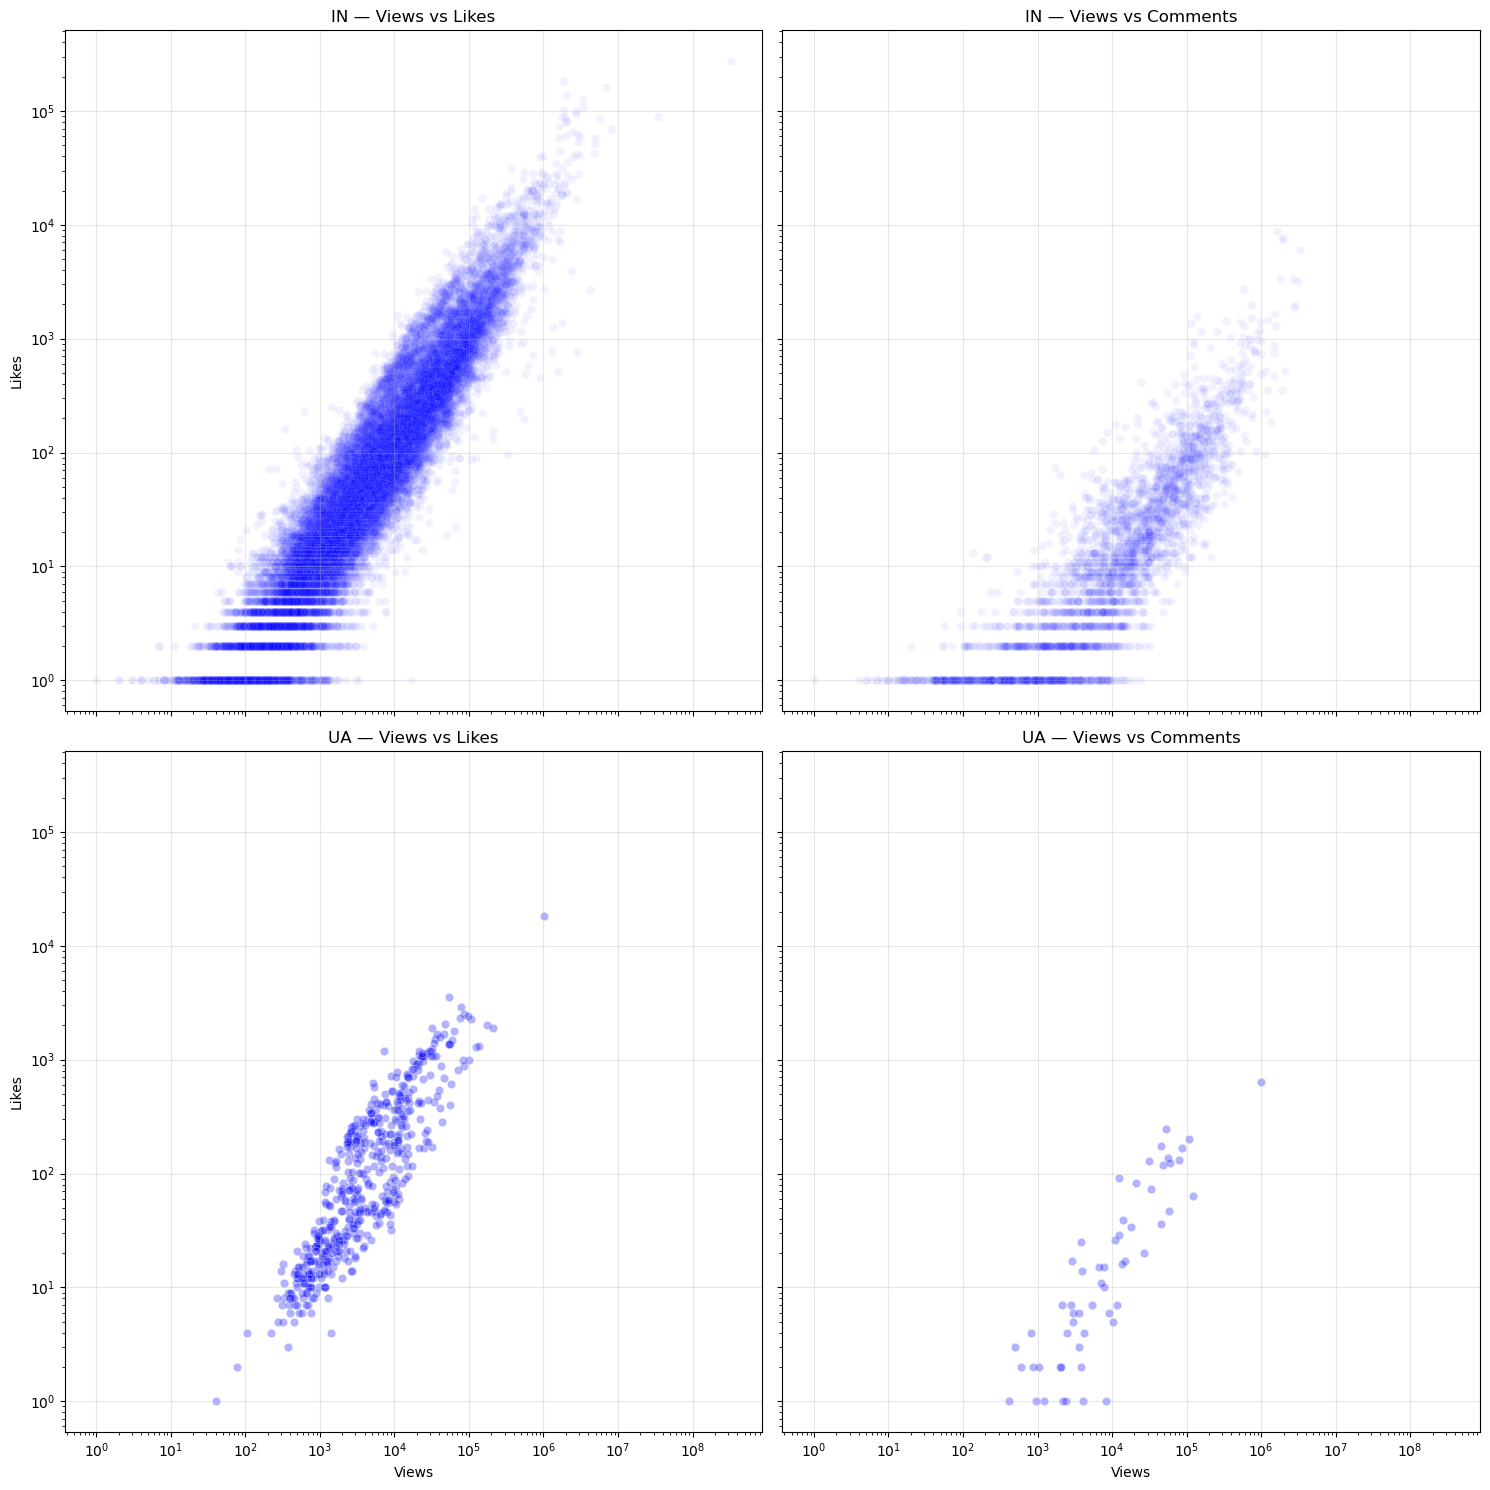

In [9]:
indian_data = df[df['country']=='IN']
ukrainian_data = df[df['country']=='UA']
stats_summary = {
    'views': ukrainian_data['view_count'].describe(),
    'likes': ukrainian_data['like_count'].describe(),
    'comments': ukrainian_data['comment_count'].describe(),
    'like_rate': ((ukrainian_data['like_count'] / ukrainian_data['view_count']) * 100).describe(),
    'comment_rate': ((ukrainian_data['comment_count'] / ukrainian_data['view_count']) * 100).describe()
}
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True)

sns.scatterplot(data=indian_data, x='view_count', y='like_count', ax=axes[0, 0], alpha=0.05, color='blue')
axes[0, 0].set_title('IN — Views vs Likes')
axes[0, 0].set_xscale("log")
axes[0, 0].set_yscale("log")
axes[0, 0].set_xlabel('Views')
axes[0, 0].set_ylabel('Likes')
axes[0, 0].grid(True, alpha=0.3)

sns.scatterplot(data=indian_data, x='view_count', y='comment_count', ax=axes[0, 1], alpha=0.05, color='blue')
axes[0, 1].set_title('IN — Views vs Comments')
axes[0, 1].set_xscale("log")
axes[0, 1].set_yscale("log")
axes[0, 1].set_xlabel('Views')
axes[0, 1].set_ylabel('Comments')
axes[0, 1].grid(True, alpha=0.3)

# Scatter plot: Views vs Likes
sns.scatterplot(data=ukrainian_data, x='view_count', y='like_count', ax=axes[1, 0], alpha=0.3, color='blue')
axes[1, 0].set_title('UA — Views vs Likes')
axes[1, 0].set_xscale("log")
axes[1, 0].set_yscale("log")
axes[1, 0].set_xlabel('Views')
axes[1, 0].set_ylabel('Likes')
axes[1, 0].grid(True, alpha=0.3)

# Scatter plot: Views vs Comments
sns.scatterplot(data=ukrainian_data, x='view_count', y='comment_count', ax=axes[1, 1], alpha=0.3, color='blue')
axes[1, 1].set_title('UA — Views vs Comments')
axes[1, 1].set_xscale("log")
axes[1, 1].set_yscale("log")
axes[1, 1].set_xlabel('Views')
axes[1, 1].set_ylabel('Comments')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

As we can see here, STEM videos created by Indians are distributes closer to lower likes and views metrics. However, the most popular Indian videos have higher engagement metrics than the most popular Ukrainian videos. Therefore, we should consider that Indian content-makers bring more content (50 times more than UA), so the low rates of the most unpopular videos influence average metrics. Let's have a closer look at the most popular STEM videos:

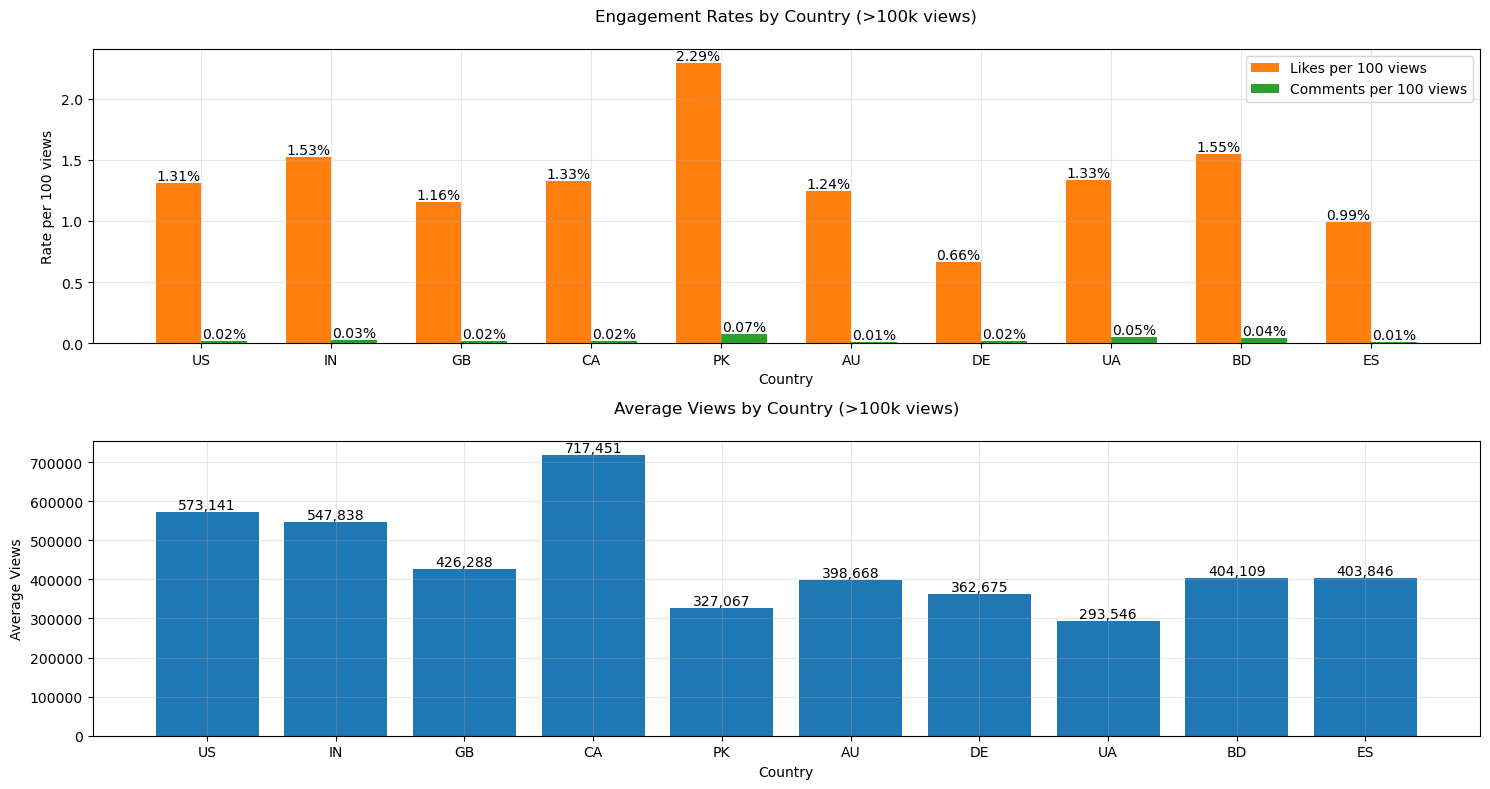

In [11]:
sample = df_top[df_top['view_count']>100000]

totals = {
    'view_count': sample['view_count'].sum(),
    'like_count': sample['like_count'].sum(),
    'comment_count': sample['comment_count'].sum()
}

metrics = list(totals.keys())
percentages = []
country_stats = []

for country in top_countries:
    country_data = sample[sample['country'] == country]
    country_percentages = {'country': country}
    country_averages = {'country': country}
    stats = {
        'country': country,
        'like_rate': (country_data['like_count'] / country_data['view_count'] * 100).mean(),
        'comment_rate': (country_data['comment_count'] / country_data['view_count'] * 100).mean(),
        'avg_views': country_data['view_count'].mean()  # Keep this for reference
    }
    country_stats.append(stats)

    for metric in metrics:
        country_percentages[metric] = (country_data[metric].sum() / totals[metric]) * 100
    percentages.append(country_percentages)
    

df_percentages = pd.DataFrame(percentages)
df_stats = pd.DataFrame(country_stats)

fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(15, 8))

# Plot 2: Engagement rates
x = np.arange(len(top_countries))
bar_width = 0.35

ax2.bar(x - bar_width/2, df_stats['like_rate'], bar_width, 
        label='Likes per 100 views', color='#ff7f0e')
ax2.bar(x + bar_width/2, df_stats['comment_rate'], bar_width, 
        label='Comments per 100 views', color='#2ca02c')

ax2.set_title('Engagement Rates by Country (>100k views)', pad=20)
ax2.set_xlabel('Country')
ax2.set_ylabel('Rate per 100 views')
ax2.set_xticks(x)
ax2.set_xticklabels(df_stats['country'])
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels on the bars
for i, v in enumerate(df_stats['like_rate']):
    ax2.text(i - bar_width/2, v, f'{v:.2f}%', ha='center', va='bottom')
for i, v in enumerate(df_stats['comment_rate']):
    ax2.text(i + bar_width/2, v, f'{v:.2f}%', ha='center', va='bottom')

# Plot 3: Average views (for reference)
ax3.bar(x, df_stats['avg_views'], color='#1f77b4')
ax3.set_title('Average Views by Country (>100k views)', pad=20)
ax3.set_xlabel('Country')
ax3.set_ylabel('Average Views')
ax3.set_xticks(x)
ax3.set_xticklabels(df_stats['country'])
ax3.grid(True, alpha=0.3)

# Add value labels on the bars
for i, v in enumerate(df_stats['avg_views']):
    ax3.text(i, v, f'{int(v):,}', ha='center', va='bottom')

plt.tight_layout()

In [ ]:
indian_popular_sample = sample[sample['country']=='IN']
indian_popular_sample.to_csv('indian_popular_sample.csv', index=False)

After comparing the rates of the videos with more than 100k views, we see that on average Indian videos engage better:

- 3rd place in likes per 100 views — right after Pakistan and Bangladesh. These countries have are represented in this data by 70 and 39 videos respectively, while India is respresented by 1781 videos. Lower number of videos can provide more outliers impacting the means, so it's more important that Idian's engagement rate is higher than American's and Great Britain's, the countries with closer numbers of highly viewed STEM videos (3517 and 316).
- 3rd place in average views — right after Canada and the USA.
- 4th place in comments per views.

The comment rates are the most difficult to interpret, so this data requires additional analysis.

## What comments tell?

### Crawling

We're crawling comments with YouTube API again. It rectricts comments crawling for up to 100 comments per video, so we're using this maximum:

In [ ]:
results = {}
fails = []
def callback(request_id: str, response: dict, exception: Exception = None):
    """Callback for video requests, adds comments as json field"""
    if exception is None:
        results[request_id] = response['items']
        comments = {}
        for item in response['items']:
            user = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
            comment = item['snippet']['topLevelComment']['snippet']['textOriginal']
            if user not in comments.keys():
                comments[user] = []
            comments[user].append(comment)
        index = sample[sample['display_id'] == request_id].index
        sample.loc[sample['display_id'] == request_id, 'comments'] = json.dumps(comments)

    else:
        fails.append(str(exception))

In [ ]:
batch_size = 50
for i in range(0, len(sample), batch_size):
    batch = youtube.new_batch_http_request()
    video_ids = sample['display_id'][i:i+batch_size]
    
    for id in video_ids:
        request = youtube.commentThreads().list(
            part='snippet',
            videoId=id,
            maxResults=100,
            order='relevance'
        )
        batch.add(request, callback=callback, request_id=id)
    batch.execute()
    
sample.to_csv('indian_sample_with_comments.csv', index=False)

### Sentiment analysis

In [12]:
def analyze_comments_sentiment(df, comment_column):
    """
    Analyze sentiment of video comments stored in JSON-like format with detailed statistics.
    Expected format: "@username": ['comment_1', 'comment_2', ...]
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing the comments
    comment_column (str): Name of the column containing JSON-like comments
    
    Returns:
    pandas.DataFrame: Original dataframe with additional sentiment columns
    dict: Summary statistics of sentiment analysis
    """
    # Initialize VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    # Create a copy to avoid modifying the original DataFrame
    analysis = df.copy()
    
    def parse_comments(comment_data):
        """Parse JSON-like string into dictionary if it's a string"""
        if isinstance(comment_data, str):
            try:
                return literal_eval(comment_data)
            except:
                try:
                    return json.loads(comment_data)
                except:
                    return {}
        return comment_data if isinstance(comment_data, dict) else {}

    def get_sentiment_label(score):
        """Determine sentiment label based on compound score"""
        if score >= 0.03:
            return 'positive'
        elif score <= -0.15:
            return 'negative'
        return 'neutral'

    def analyze_comment_group(comment_data):
        """Analyze sentiment for a group of comments from one entry"""
        comments_dict = parse_comments(comment_data)
        all_scores = []
        all_comments = []
        sentiment_counts = {'positive': 0, 'negative': 0, 'neutral': 0}
        sentiment_scores = []
        
        for username, comments in comments_dict.items():
            if not isinstance(comments, list):
                comments = [comments]
            
            for comment in comments:
                if pd.isna(comment) or not comment:
                    continue
                    
                scores = analyzer.polarity_scores(str(comment))
                compound_score = scores['compound']
                sentiment = get_sentiment_label(compound_score)
                
                sentiment_counts[sentiment] += 1
                sentiment_scores.append(compound_score)
                
                all_comments.append({
                    'username': username,
                    'comment': comment,
                    'score': compound_score,
                    'sentiment': sentiment
                })
        
        if not sentiment_scores:
            return {
                'avg_compound': 0,
                'sentiment': 'neutral',
                'comment_count': 0,
                'comments_detail': [],
                'sentiment_counts': sentiment_counts,
                'sentiment_scores': [],
                'positive_ratio': 0,
                'negative_ratio': 0,
                'neutral_ratio': 0
            }
            
        total_comments = len(sentiment_scores)
        avg_compound = np.mean(sentiment_scores)
        
        return {
            'avg_compound': avg_compound,
            'sentiment': get_sentiment_label(avg_compound),
            'comment_count': total_comments,
            'comments_detail': all_comments,
            'sentiment_counts': sentiment_counts,
            'sentiment_scores': sentiment_scores,
            'positive_ratio': sentiment_counts['positive'] / total_comments,
            'negative_ratio': sentiment_counts['negative'] / total_comments,
            'neutral_ratio': sentiment_counts['neutral'] / total_comments
        }
    
    # Apply sentiment analysis to each comment group
    results = analysis[comment_column].apply(analyze_comment_group)
    
    # Add new columns to DataFrame
    analysis['sentiment_score'] = results.apply(lambda x: x['avg_compound'])
    analysis['sentiment_label'] = results.apply(lambda x: x['sentiment'])
    analysis['comment_count'] = results.apply(lambda x: x['comment_count'])
    analysis['comments_detail'] = results.apply(lambda x: x['comments_detail'])
    analysis['sentiment_counts'] = results.apply(lambda x: x['sentiment_counts'])
    analysis['sentiment_scores'] = results.apply(lambda x: x['sentiment_scores'])
    analysis['positive_ratio'] = results.apply(lambda x: x['positive_ratio'])
    analysis['negative_ratio'] = results.apply(lambda x: x['negative_ratio'])
    analysis['neutral_ratio'] = results.apply(lambda x: x['neutral_ratio'])
    
    # Calculate total sentiment counts across all entries
    total_sentiment_counts = {
        'positive': sum(x['positive'] for x in analysis['sentiment_counts']),
        'negative': sum(x['negative'] for x in analysis['sentiment_counts']),
        'neutral': sum(x['neutral'] for x in analysis['sentiment_counts'])
    }
    
    total_comments = sum(total_sentiment_counts.values())
    
    # Calculate summary statistics
    summary = {
        'total_entries': len(analysis),
        'total_comments': total_comments,
        'comments_per_entry': total_comments / len(analysis) if len(analysis) > 0 else 0,
        
        # Entry-level statistics
        'positive_entries': sum(analysis['sentiment_label'] == 'positive'),
        'negative_entries': sum(analysis['sentiment_label'] == 'negative'),
        'neutral_entries': sum(analysis['sentiment_label'] == 'neutral'),
        
        # Comment-level statistics
        'positive_comments': total_sentiment_counts['positive'],
        'negative_comments': total_sentiment_counts['negative'],
        'neutral_comments': total_sentiment_counts['neutral'],
        
        # Sentiment scores statistics
        'average_sentiment': analysis['sentiment_score'].mean(),
        'sentiment_std': analysis['sentiment_score'].std(),
        'min_sentiment': min(analysis['sentiment_score']),
        'max_sentiment': max(analysis['sentiment_score']),
        
        # Distribution metrics
        'sentiment_quartiles': np.percentile(
            [score for scores in analysis['sentiment_scores'] for score in scores],
            [25, 50, 75]
        ).tolist() if total_comments > 0 else [0, 0, 0]
    }
    
    # Add percentage calculations
    summary.update({
        # Entry-level percentages
        'positive_entries_percentage': (summary['positive_entries'] / summary['total_entries'] * 100),
        'negative_entries_percentage': (summary['negative_entries'] / summary['total_entries'] * 100),
        'neutral_entries_percentage': (summary['neutral_entries'] / summary['total_entries'] * 100),
        
        # Comment-level percentages
        'positive_comments_percentage': (total_sentiment_counts['positive'] / total_comments * 100) if total_comments > 0 else 0,
        'negative_comments_percentage': (total_sentiment_counts['negative'] / total_comments * 100) if total_comments > 0 else 0,
        'neutral_comments_percentage': (total_sentiment_counts['neutral'] / total_comments * 100) if total_comments > 0 else 0
    })
    
    return analysis, summary

In [16]:
df = pd.read_csv('data/indian_sample_with_comments.csv')
df = df[df['comments'].notna()].reset_index()
analysis, summary = analyze_comments_sentiment(df, 'comments')
summary

{'total_entries': 1651,
 'total_comments': 141003,
 'comments_per_entry': 85.404603270745,
 'positive_entries': 1640,
 'negative_entries': 0,
 'neutral_entries': 11,
 'positive_comments': 94561,
 'negative_comments': 7405,
 'neutral_comments': 39037,
 'average_sentiment': 0.35167341272978947,
 'sentiment_std': 0.13546574947867068,
 'min_sentiment': -0.0792081081081081,
 'max_sentiment': 0.7563860000000001,
 'sentiment_quartiles': [0.0, 0.4215, 0.658],
 'positive_entries_percentage': 99.33373712901272,
 'negative_entries_percentage': 0.0,
 'neutral_entries_percentage': 0.6662628709872804,
 'positive_comments_percentage': 67.06311213236597,
 'negative_comments_percentage': 5.251661312170663,
 'neutral_comments_percentage': 27.68522655546336}

([<matplotlib.patches.Wedge at 0x160bf1460>,
 [Text(-0.5618217010721164, 0.9457041694972238, 'positive comments'),
  Text(-0.3602990509816452, -1.0393192935098077, 'negative comments'),
  Text(0.7095133525850887, -0.8405895565039265, 'neutral comments')],
 [Text(-0.3064482005847907, 0.5158386379075766, '67.1%'),
  Text(-0.19652675508089737, -0.5669014328235314, '5.3%'),
  Text(0.3870072832282302, -0.4585033944566871, '27.7%')])

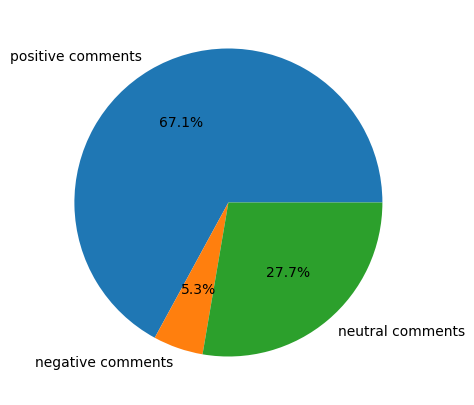

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,5))
ax.pie([summary['positive_comments_percentage'], summary['negative_comments_percentage'], summary['neutral_comments_percentage']],
       labels = ['positive comments', 'negative comments', 'neutral comments'], autopct='%1.1f%%')

Let us visualise a sample of 10 for each sentiment group:

In [26]:
def sample_comments_by_sentiment(analyzed_df, n_samples=10):
    """
    Sample n comments from each sentiment category (positive, negative, neutral)
    from the analyzed DataFrame.
    
    Parameters:
    analyzed_df (pandas.DataFrame): DataFrame with sentiment analysis results
    n_samples (int): Number of comments to sample from each category
    
    Returns:
    dict: Dictionary containing sampled comments for each sentiment category
    """
    # Flatten the comments_detail lists from all entries
    all_comments = []
    for details in analyzed_df['comments_detail']:
        all_comments.extend(details)
    
    # Convert to DataFrame for easier filtering
    comments_df = pd.DataFrame(all_comments)
    
    # Sample comments from each sentiment category
    samples = {}
    for sentiment in ['positive', 'negative', 'neutral']:
        category_comments = comments_df[comments_df['sentiment'] == sentiment]
        
        # If there are fewer comments than requested samples, take all available
        n_available = min(n_samples, len(category_comments))
        
        if n_available > 0:
            sampled = category_comments.sample(n=n_available, random_state=42)
            samples[sentiment] = sampled.to_dict('records')
        else:
            samples[sentiment] = []
            
    return samples

In [27]:
samples = sample_comments_by_sentiment(analysis)

for group in samples:
    print('-'*100,f'\n{group.upper()}:') 
    for comment in samples[group]:
        print('\t', comment['comment'].encode("utf16", errors="surrogatepass").decode("utf16").replace('\n', ''))

---------------------------------------------------------------------------------------------------- 
POSITIVE:
	 Thank you guru jiii
	 Jo bhi dislikers Ho Kahi BhI Dhundhlo tumhe isse best lecture Kahi nahi milega
	 Basic pay 12750. Grade pay -4100. Joining date- 25.01.2019.  9-10 teacher. Dada anumanik salary koto hote pare. Please  dada ektu bolben.
	 these videos are Awesome but not in a sequencial manner we are getting confused...please make proper playlist of topis with complete topocs. thankyou
	 this vedio is very nice and are all parts are to the point .
	 Simply best....
	 Apko andaja hona chahie ki aapke pas h............... .........Knowledge :P
	 Amazing series...its helping me a lot...please do continue this series and that left out parts :-)
	 Bro plz make a video on govt central Universities which has BSC biotechnology courses
	 i like all the videos of etoos education
---------------------------------------------------------------------------------------------------- 


The majority of comments are positive. The negative comments often contain complains on the audio quality or mistakes. Since most popular Indian STEM content has only 0.03 comments per 100 views, the number of negative comments is only 0.0081 per 100 views.